# Asympotic behavour of Bayesian multiple testing

###  $$ p:= P(\gamma_i \neq 0)  \sim Be(1,1)  \qquad \forall 1\leq i \leq m$$  $$ P(M_\gamma) = \int^1_0 p(M_\gamma \mid p) \pi(p) dp =\frac{1}{m+1} \frac{1}{\binom{m}{k_\gamma}} $$  In this article, "Average Bayes factors of m,k " represents for:      $$  \frac{1}{\binom{m}{k_\gamma}}  \sum \limits_{\gamma : |\gamma|=k} B_{\gamma 0}(x)  $$  where the Bayes factor equals  $$B_{\gamma 0}(x) = \prod \limits_{i:\gamma(i)\neq 0} \frac{1}{\sqrt{1+\tau^2}}\exp \{\frac{1}{2}x_i^2\delta \} $$  $$ \delta = \frac{\tau^2}{1+\tau^2}$$

##### Required packages and functions

In [1]:
import random
import scipy as sp
import numpy as np

import itertools
from operator import mul
from functools import reduce
from math import exp, log, gamma
from scipy import misc, special
import matplotlib.pyplot as plt


def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(xrange(n), r))
    return tuple(pool[i] for i in indices)

def calc_full(dat, k, tau):
    """ input: observations from m channels and 1<= w <= m integer 
        output: average Bayes factor among all models with the same model complexity w (i.e. w out of m channels have nonzero mean)
        calculate ALL distinct w consecutive products within the string A, e.g.:
        If w = 1 , return [A(1)+A(2)+A(3)]/3
        If w = 2 , return [A(1)A(2)+A(1)A(3)+A(2)A(3)] /3 
        If w = 3 , return [A(1)A(2)A(3)]/1 
    """
    delta = tau**2 / (1.0 + tau**2)
    A =  map(lambda x: (1.0 + tau **2)**(-0.5) * exp(delta /2.0 * x**2), dat )
    if k >= 1 and k <= len(A):
        l = [reduce(mul, comb) for comb in itertools.combinations(A, k)]
        return sum(l)/len(l)  #return average
    else:
        print 'Error: k>m or k=1'

def sum_Bayes_full(dat, k, tau):
    delta = tau**2 / (1.0 + tau**2)
    A =  map(lambda x: (1.0 + tau **2)**(-0.5) * exp(delta /2.0 * x**2), dat )
    if k >= 1 and k <= len(A):
        l = [reduce(mul, comb) for comb in itertools.combinations(A, k)]
        return sum(l)  #return average
    elif k == 0 :
        return 1
    else:
        print 'Error: k>m or k=1'
        
def prior(m,k,a,b):
    '''For any fixed m, return prior for all models with model complexity 0<=k <=m
       when a = b = 1, return 1/(m+1)/C(m,k)'''
    return sp.special.beta(a+k, b+m-k) / sp.special.beta(a, b)

def prior_null(m,k):
    ''' this prior put 0.5 weight on the null model'''
    if k == 0:
        return 0.5
    else:
        return 0.5 / m / sp.misc.comb(m,k)

def calc_rnd(dat, k, r, tau):
    """ input: A: array of log-likelihoods, k: model complexity, r:# of random samples from C(m,k) models with the same k
        output: average of likelihoods among these r samples.
        randomly select r samples out of C(len(A),k pool. 
        The pool consists of all distinct summation within the string A (= log likelihood)
        If (n,w,r)=(3,2,1): randomly draw 1 sample from A(1)+A(2) , A(1)+A(3) , A(2)+A(3)
    """
    delta = tau**2 / (1.0 + tau**2)
    A =  map(lambda x: -0.5 * log(1.0 + tau **2) + x**2*delta / 2.0 , dat)  #log-likelihood
    #l = [reduce(mul, comb) for comb in random_combination(itertools.combinations(A,k), r)] 
    l = [ sum(comb) for comb in random_combination(itertools.combinations(A,k), r)] 
    B = map(exp, l)
    return round(sum(B)/len(B),7)


#def calc_beta(dat, k, r,a,b, tau):
#    m = len(dat)
#    return round(calc_rnd(dat,k,r, tau)*m*gamma(a+b)/gamma(a)/gamma(b)*gamma(m-k+a)*gamma(b+k)/gamma(m+a+b), 7)

def calc2_rnd(dat, k, r, tau):
    delta = tau**2 / (1.0 + tau**2)
    A =  map(lambda x: (1.0 + tau **2)**(-0.5) * exp(delta /2.0 * x**2), dat )  #log-likelihood
    if k >= 1 and k <= len(A):
        l = [reduce(mul,comb) for comb in random_combination(itertools.combinations(A,k), r)] 
    return sum(l)/len(l)  #return average

def log_elementwise(temp_input):
    'take log elementwise of [[],[],...,[]]'
    empty = []
    jj = 0
    for lists in temp_input:
        empty.append([])
        empty[jj] = np.log(lists)
        jj += 1
    return empty



### Posterior probability   $$ P(M_i\mid X) = \frac{p_i B_{i0}(x) }{\sum \limits^{2^m}_{l=1} p_l B_{l0}(x)}$$  In particular,  $$ P(M_0\mid X) = \frac{p_0 }{\sum \limits^{2^m}_{l=1} p_l B_{l0}(x)} = \bigg(1+ \frac{1}{p^{(0)}}\sum \limits^m_{i=1}p^{(i)} \sum\limits_{|\gamma|=i } B_{\gamma 0} \bigg)^{-1}$$  where $$p^{(i)} = P(M_\gamma: |\gamma|=i)$$  If    $ p\sim Beta(a,b)$         $$p^{(i)} =  \frac{Be(a+k,b+m-k)}{Be(a,b)} $$         

### False positive rate

### For any i $\in \{1,2,...,m\}$, the posterior inclusion probability of variable i is:  $$ p_i = P(\mu_i \neq 0 \mid X) =\sum \limits_{\gamma : \gamma(i)=1} p(M_\gamma\mid X) $$  And the false positive probability is:  $$ P(max_{1\leq i \leq m} p_i >0.5 \mid M^{(0)})  $$  other interesting quanities include:  $$ \frac{1}{m} E(\#\{i : p_i >0.5 \} \mid M^{(0)} ) $$

In [9]:
import heapq
top_n = 3
x = np.random.normal(0,1,10)
print x

x_abs = map(lambda s:abs(s),x)
print x_abs 

temp = heapq.nlargest(top_n, enumerate(x_abs), key=lambda seq: seq[1])  # sort and extract top n numbers 
index = map(lambda seq: seq[0], temp)                                   # extract index from the list
print index

sp.special.beta(0.5,0.5)

[-0.40713256  0.43242518 -0.33422968 -0.29429121  0.34944128  0.33107028
 -0.1394884   1.37744495 -0.35243948  0.85982596]
[0.40713256205830312, 0.43242517770819644, 0.33422968419856636, 0.29429120838211914, 0.34944127928670421, 0.3310702776556218, 0.13948840046086552, 1.3774449476521293, 0.35243948137973219, 0.85982596084037899]
[7, 9, 1]


3.1415926535897927

In [21]:
## interate over all 2^m models to compute the denominator
## see if the model containing top_n observations has posterior > 0.5
## see if the null model has posterior > 0.5

import heapq
m = 20
top_n = 10

x = np.random.normal(0,1,m)

tau = 1
delta = tau**2 / (1. + tau**2)
iters = 250
    
result = []
models_prior = []

# compute the posterior
#models_prior = []
denom = 0
for k in xrange(0,m+1):
    models_prior.append(prior(m,k,1,1))
    denom += (sum_Bayes_full(x, k, tau) * models_prior[k])
print 'denom is ' + str(denom)
    
post_top_n = []
x_abs = map(lambda s:abs(s),x) 
x_top_n = heapq.nlargest(top_n, enumerate(x_abs), key=lambda seq: seq[1])  # sort and extract top n numbers 
x_top_n_sq = map(lambda seq: seq[1]**2, x_top_n)                                   # extract index from the list

for ii in xrange(1,top_n + 1):
    Bayes_top_n = ((1. + tau**2)**(-ii / 2.0)) * exp( delta / 2.0 * sum(x_top_n_sq[0:ii]))
    post_top_n.append(round((Bayes_top_n * models_prior[ii]), 6))
    
print 'approx is ' + str(sum(post_top_n)*2**m)

post_null = round((sum_Bayes_full(x, 0, tau) * models_prior[0]) / denom, 6)  #posterior of the null model


print Bayes_top_n
print sum_Bayes_full(x,top_n, tau)

print post_null, post_top_n


denom is0.446009715792
approx is5872.0256
1.69136484346
70215.4550226
0.106767 [0.004603, 0.000769, 0.00017, 3.9e-05, 1.1e-05, 4e-06, 2e-06, 1e-06, 1e-06, 0.0]


### $P(M_0 \mid X)$ under null model:

In [31]:
def null_post_under_null(a,b):
    ## full copmutation
    tau = 1
    #result = 1.  #Bayes factor of null model
    iters = 250
    
    ii = 0
    result = []
    m_init, m_end, m_items =10 , 20 , 5
    m_domain = map(int, np.linspace(m_init, m_end, m_items))

    for m in m_domain:
        jj = 0
        result.append([])
        models_prior = []
        for k in xrange(0,m+1):
            models_prior.append(prior(m,k,a,b))
        #
        # Bayes factor
        while jj<iters:
            x = np.random.normal(0,1,m) 
            temp = 0.
            for k in xrange(0,m+1):
                temp += (sum_Bayes_full(x, k, tau) * models_prior[k])
                #(models_prior[k] * calc_full(x, k, tau) * sp.misc.comb(m[ii],k))   #note: calc_full returns average of Bayes factors with the same m.c. k
            temp2 = round((sum_Bayes_full(x, 0, tau) * models_prior[0]) / temp, 6)
            result[ii].append( temp2 ) 
            jj += 1
        ii += 1
        #print result
    #plt.boxplot(elementwise(result))
    plt.boxplot(result)
    plt.title('Posterior probability of null model under null, (a,b)=('+ str(a) + ',' +str(b)+')' )
    plt.ylabel('posterior probability')
    plt.xlabel('m')
    pylab.xticks(range(1,len(m_domain)+1), m_domain)  
    plt.show()
 
    

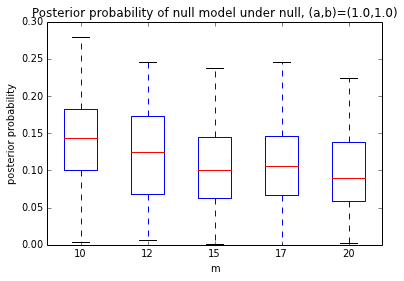

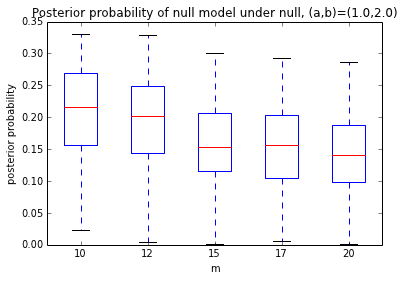

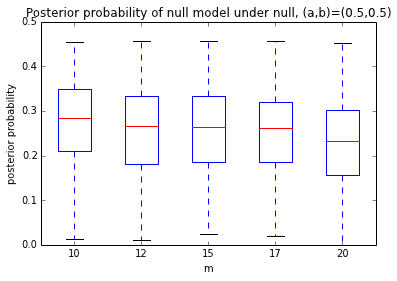

In [32]:
figure(1)
null_post_under_null(1.,1.)
figure(2)
null_post_under_null(1.,2.)
figure(3)
null_post_under_null(0.5,0.5)

In [28]:
   
def null_post_under_null0():
    ''' P(M0)=0.5, P(M_k)= 1/m/C(m,k)'''
    tau = 1
    #result = 1.  #Bayes factor of null model
    iters = 250
    
    ii = 0
    result = []
    m_init, m_end, m_items =10 , 20 , 5
    m_domain = map(int, np.linspace(m_init, m_end, m_items))

    for m in m_domain:
        jj = 0
        result.append([])
        models_prior = []
        for k in xrange(0,m+1):
            #models_prior.append(prior(m,k,a,b))
            models_prior.append(prior_null(m,k))
        #
        # Bayes factor
        while jj<iters:
            x = np.random.normal(0,1,m) 
            temp = 0.
            for k in xrange(0,m+1):
                temp += (sum_Bayes_full(x, k, tau) * models_prior[k])
                #(models_prior[k] * calc_full(x, k, tau) * sp.misc.comb(m[ii],k))   #note: calc_full returns average of Bayes factors with the same m.c. k
            temp2 = round((sum_Bayes_full(x, 0, tau) * models_prior[0]) / temp, 6)
            result[ii].append( temp2 ) 
            jj += 1
        ii += 1
        #print result
    #plt.boxplot(elementwise(result))
    plt.boxplot(result)
    plt.title('Posterior probability of null model under null' )
    plt.ylabel('posterior probability')
    plt.xlabel('m')
    pylab.xticks(range(1,len(m_domain)+1), m_domain)  
    plt.show()

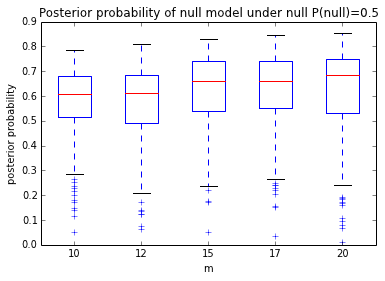

In [30]:

null_post_under_null0()
plt.title('Posterior probability of null model under null P(null)=0.5' )


In [91]:
def full_post_under_full(a,b):
    ## full copmutation
    tau = 1
    #result = 1.  #Bayes factor of null model
    iters = 100
    
    ii = 0
    result = []
    m_init, m_end, m_items =10 , 20 , 5
    m_domain = map(int, np.linspace(m_init, m_end, m_items))

    for m in m_domain:
        jj = 0
        result.append([])
        models_prior = []
        for k in xrange(0,m+1):
            models_prior.append(prior(m,k,a,b))
        #
        # Bayes factor
        while jj<iters:
            x = np.random.normal(0,1.+ tau ,m) 
            temp = 0.
            for k in xrange(0,m+1):
                temp += (sum_Bayes_full(x, k, tau) * models_prior[k])
                #(models_prior[k] * calc_full(x, k, tau) * sp.misc.comb(m[ii],k))   #note: calc_full returns average of Bayes factors with the same m.c. k
            temp2 = round((sum_Bayes_full(x, m, tau) * models_prior[m]) / temp, 6)
            result[ii].append( temp2 ) 
            jj += 1
        ii += 1
        print result
    #plt.boxplot(elementwise(result))
    plt.boxplot(result)
    plt.title('Posterior probability of full model under null, (a,b)=('+ str(a) + ',' +str(b)+')' )
    plt.ylabel('posterior probability')
    plt.xlabel('m')
    pylab.xticks(range(1,len(m_domain)+1), m_domain)    

###  Bayes factor of the full model (versus null model)

tau =0.1;mean  0.993007720184; std is 0.221167864879
tau =0.5;mean  0.0441604704765; std is 0.51759661807
tau =1.0;mean  1.60780294674e-26; std is 3.59154670964e-25
tau =1.5;mean  7.2792126842e-89; std is 1.36373973365e-87
tau =2.0;mean  2.58759065764e-154; std is 5.73079851198e-153


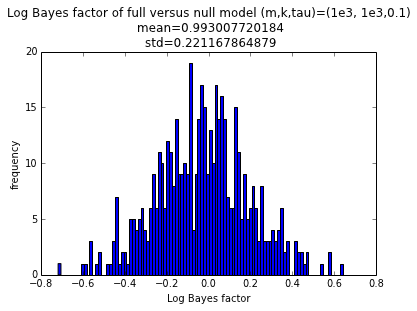

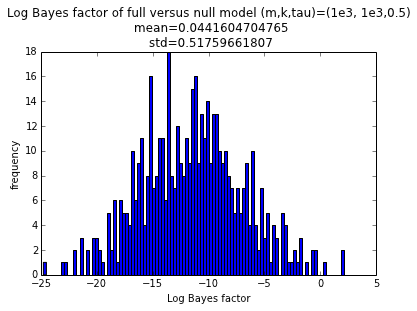

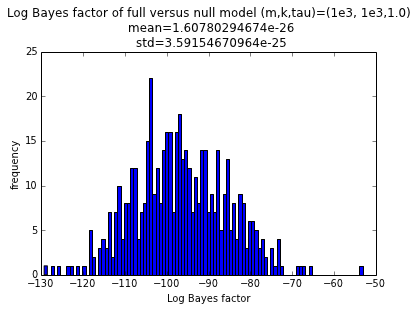

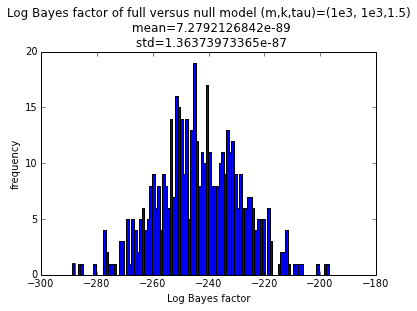

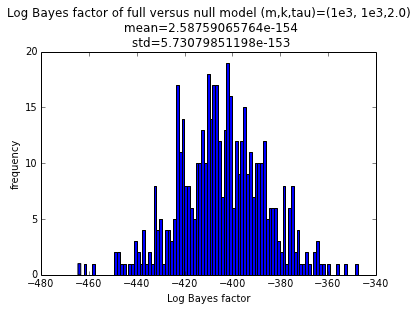

In [25]:
# Bayes factor of the full model (versus null model)
import numpy as np
def BF_full(tau):
    dat =[]
    jj = 0
    m = 1000
    while jj < 500:
        x = np.random.normal(0,1,m)
        x_sq = map(lambda t: t**2, x)
        temp = exp((-m / 2.0)*log(1.0+ tau**2) + 0.5* (tau**2)/(1.0+tau**2) * sum(x_sq))
        dat.append(temp)
        #dat.append(calc_full(x, m-1, 1.0))
        jj += 1
    print 'tau =' +str(tau) + ";mean  " +str(mean(dat)) + "; std is " +str(std(dat))
    #plt.boxplot(dat)
    #plt.boxplot(log_elementwise(dat))
    #print mean(dat), std(dat)
    plt.hist(map(log,dat), 100)
    title('Log Bayes factor of full versus null model (m,k,tau)=(1e3, 1e3,'+str(tau)+ ')\n mean=' +str(mean(dat))+'\n std='+str(std(dat)))
    xlabel('Log Bayes factor')
    ylabel('frequency')

index = [0.1, 0.5, 1., 1.5, 2.]
for ii in xrange(0, len(index)):    
    figure(ii)
    BF_full(index[ii])


### Arithemetic mean of Bayes factors with the same k (k=m,m-1,m-2,..,2,1):       $$   \frac{1}{\binom{m}{k}} \sum \limits_{\gamma : |\gamma|=k} B_{\gamma 0}(x) $$      Remark: m = Number of channels; k = model complexity. 

In [69]:
 ## For any m, k=m OR m-1 OR... OR 1 OR 2

m_init, m_end, m_num_pts = 10, 50, 10
m_domain = map(int, np.linspace(m_init, m_end, m_num_pts))


def generator_full(dim,a,b):
    tau = 1.0
    #r = tau**2 / (1.0 + tau**2)
    iters = 100                     # number of iterations
    result_array = []              # num_of_ms 
    jj = 0
    for m in m_domain:
        result_array.append([])
        if dim>0 and dim<=m:        #if dim>0, k=dim
            k = dim
            names = str(dim)
        elif dim<0 and abs(dim)<=m: #if dim<0, k=m-|dim|
            k = int(m+dim)
            names = "m"+str(dim)
        else:
            k = m                  # default k=m
            names = str("m")
        #sample_size = misc.comb(int(m), int(k), exact = True)
        sample_size = int(log(misc.comb(int(m), int(k), exact=True))+1)                # must be smaller than the population size, i.e. C(m,k)
        #print  ' m is '+ str(m) + '; k is '+ str(k) + "; sample size is "  + str(sample_size) 
        for ii in xrange(0, iters):
            x = np.random.normal(0,1,m)
            if (a<0 or b<0 or a>1 or b>1): #use arithmetic mean , no prior  
                #temp = calc_rnd(x,k,sample_size,1.0)
                #temp = calc_full(x,k,1.0)
                temp = sum_Bayes_full(x,k,1.0) / misc.comb(int(m),int(k))
                plt.title("Average of Bayes factor likelihoods with k =" + names )
            else: 
                temp =calc_rnd(x,k,sample_size,1.0) * sample_size * prior(m,k,a,b)
                plt.title("Average of Bayes factor likelihoods with k =" + names + ";a=" +str(a)+ ";b="+str(b))
            #print temp
            result_array[jj].append(temp)
        #print result_array[jj]
        #print mean(result_array[jj])
        jj += 1
    #plot
    #plt.boxplot(log_elementwise(result_array))
    plt.boxplot(result_array)
    #plt.ylabel('Log Average Bayes factors')
    plt.ylabel('Average Bayes factors')
    plt.xlabel('m')
    pylab.xticks(range(1,len(m_domain)+1), m_domain)
    return result_array


### Arithmetic mean (for each m, k=1 OR 2 OR... OR m) 

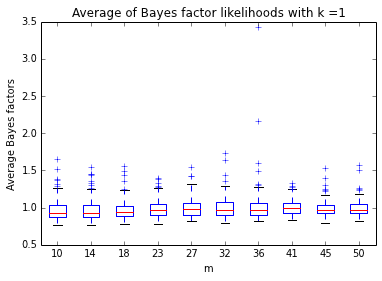

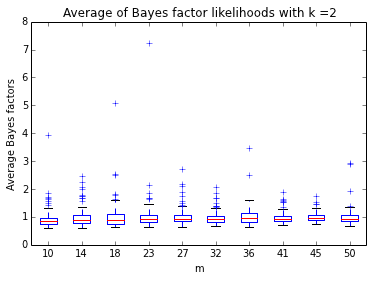

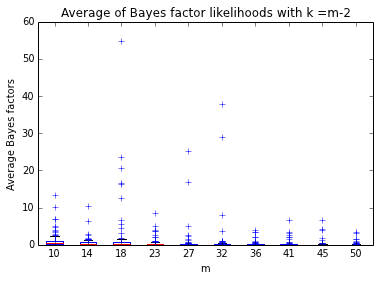

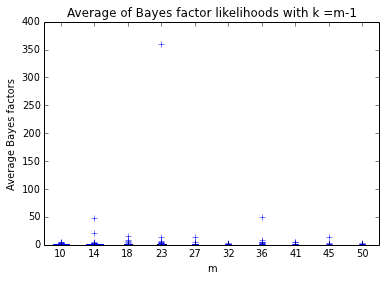

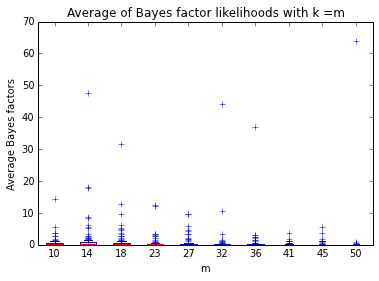

In [70]:
plt.close()
index = [1,2,-2,-1,-2000]

for ii in xrange(0,len(index)):
    figure(ii)
    generator_full(index[ii],10,10)
    
plt.show()

###  Now consider the following "average" among all models with the same k: $$ p^{(k)}  \sum \limits_{\gamma : |\gamma|=k} B_{\gamma 0}(x)  $$  Note that (a,b)=(1,1) is equivalent to the arithmetic mean up to a proportional constant $\frac{1}{m+1}$       $$   \frac{1}{(m+1)\binom{m}{k_\gamma}} \sum \limits_{\gamma : |\gamma|=k} B_{\gamma 0}(x) $$

### average with (a,b)=(1,1)

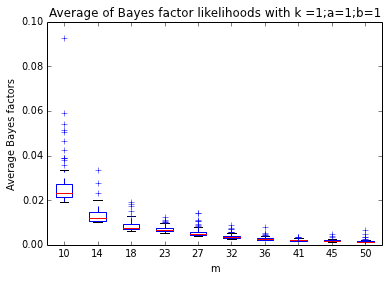

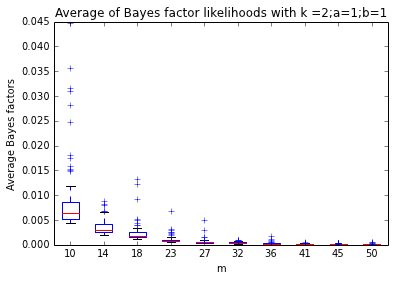

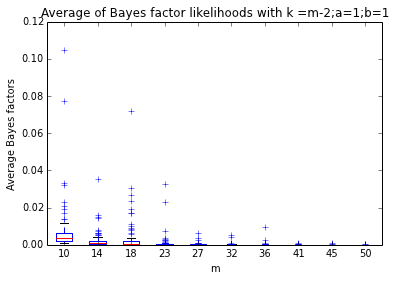

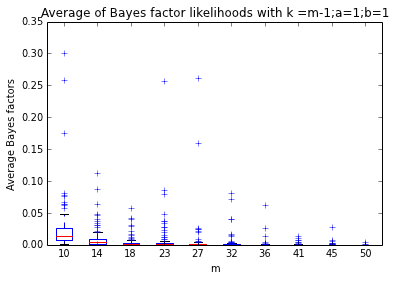

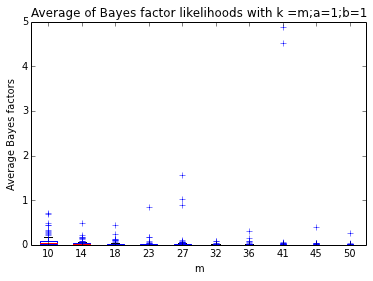

In [71]:
# average, no a,b
plt.close()
index = [1,2,-2,-1,-2000]
for ii in xrange(0,len(index)):
    figure(ii)
    generator_full(index[ii],1,1)
    
plt.show()

### average with (a,b)=(1,2)

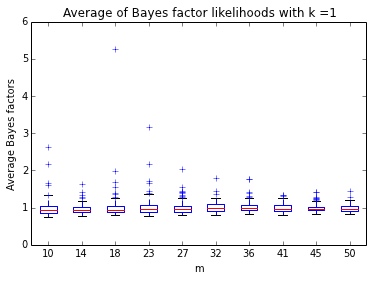

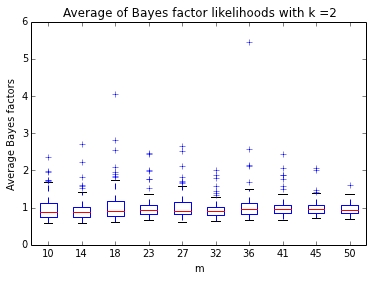

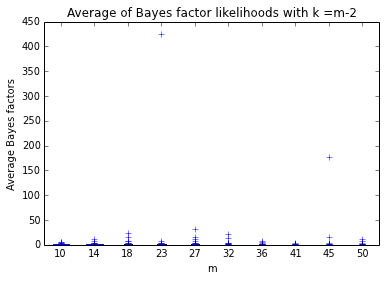

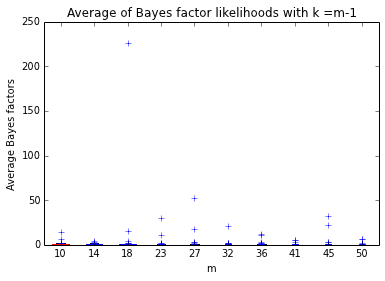

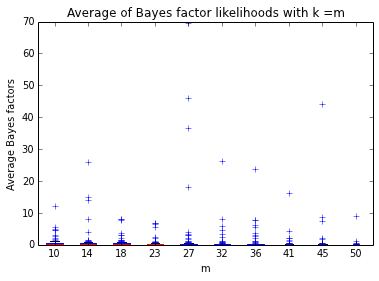

In [72]:
# (a,b)=(1,2) i.e. pdf of prior p is a triangle, penalize complex models
for ii in xrange(0,len(index)):
    figure(ii)
    generator_full(index[ii],1,2)
plt.show()

### average with (a,b)=(0.5,0.5)

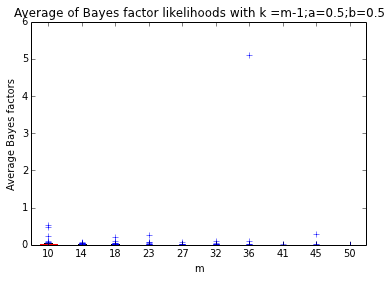

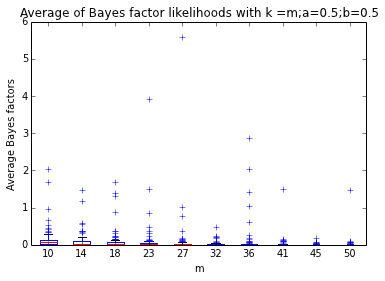

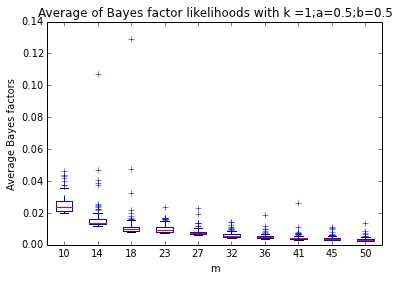

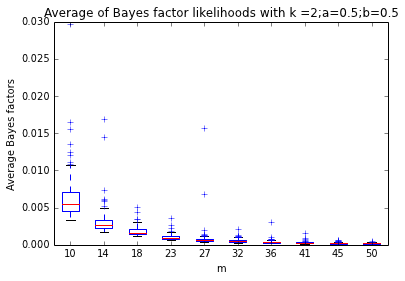

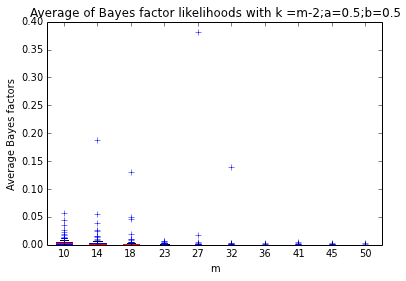

In [74]:
# p(M_\gamma)  \s# (a,b)=(0.5,0.5)
for ii in xrange(0,len(index)):
    figure(ii+5)
    generator_full(index[ii],0.5,0.5)
plt.show()

###  Fixed m, compute k=1:m

In [57]:
# Fixed m, compute k=1:m
tau = 1.0
#r = tau**2 / (1.0 + tau**2)
iters = 1e2                      # number of iterations
#m = 40                        # number of channels

def fixed_m_generator(m,tau):
    k_init, k_end, k_num_pts = 1 , m , 10
    k_domain = map(int, np.linspace(k_init, k_end, k_num_pts))
    result = []
    jj = 0
    for k in k_domain:
        sample_size = int(log(misc.comb(int(m), int(k), exact=True))+1)               # must be smaller than the population size, i.e. C(m,k)
        ii = 0 
        result.append([])
        #print " k = " + str(k) + "; sample size = " + str(sample_size) 
        while ii<iters:
            x = np.random.normal(0,1,m)
            temp = calc_rnd(x, k, sample_size, tau)  #use log-likelihood version
            #print temp
            result[jj].append(temp)
            ii += 1
        #print result[jj]
        jj += 1
    #plot
    #print result
    plt.boxplot(log_elementwise(result))
    #plt.boxplot(result)
    plt.xlabel('k')
    plt.ylabel('average Bayes factors')
    pylab.xticks(range(1,len(k_domain)+1), k_domain)
    plt.title("Fixed m = "+ str(m) +"; different k")
    return result

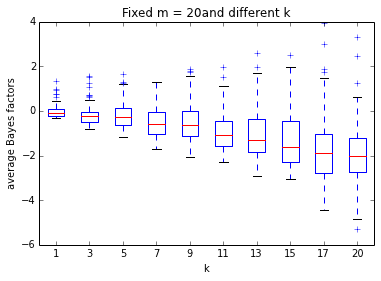

In [55]:
figure(1)
fixed_m_generator(20,1.0)
figure(2)
fixed_m_generator(30,1.0)
plt.show()

## Appendix:

In [34]:
# randomly select 2^k / 10 out of 2^k models
m = 10
sample_size = 2**m / 10.0                                         #for efficient, not computing Bayes factors of all 2^k models
models = np.random.binomial(1, .5 , (sample_size,m))
cpx = map(sum, models)                                            # model size for each model

models_prior = []
for k in xrange(0,m):
    models_prior.append(round(1.0 / sp.misc.comb(m,k) /(m+1),5))  #prior for models with model complexity i=0:m
print models_prior    

cpx = map(lambda x: models_prior[x] ,cpx1)                        #prior for each model

x = np.random.normal(0,1,m)                                       #data

for item in itertools.combinations([1,2,3],2):
    print item




[0.09091, 0.00909, 0.00202, 0.00076, 0.00043, 0.00036, 0.00043, 0.00076, 0.00202, 0.00909]
(1, 2)
(1, 3)
(2, 3)


#### plots

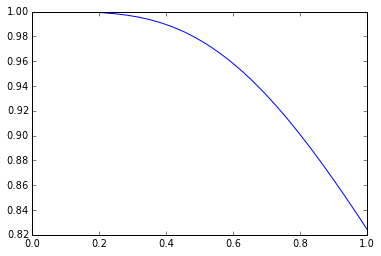

In [18]:
import numpy as np
from math import exp
tau_pts = np.linspace(0.01, 1 , 30)
curve1 = np.array(map(lambda x: exp(x**2 / (1. + x**2)), tau_pts))
curve2 = np.array(map(lambda x: 1+x**2, tau_pts))

plot(tau_pts, curve1 / curve2)

#import matplotlib as plt
#plot(tau_pts, curve1)
#plot(tau_pts, curve2)
#plt.show()

In [14]:
def plot_fixed_m(dat, m, k_domain):
    plt.boxplot(log_elementwise(dat))
    plt.xlabel('k') 
    plt.ylabel('log-average Bayes factors')
    pylab.xticks(range(1,len(k_domain)+1), k_domain)
    plt.title("Fixed m = "+str(m)+ ",different k, (a,b)=(1,1)")

figure(0)
result = [[1739.6432289015538, 4.0133272162299454, 8.8153136792878328, 51.598819464807569, 603.32323723193281, 2.4720420086890793, 1.8812967552539259, 3687.6294131924528, 12.440875707612641, 2161.7131455034009, 2.1556884864428181, 1.8804732051814892, 2.6625047105881765, 5.8563333058382545, 2.6294464753779607, 24.177318971510122, 32.633649051381816, 10.536800668733013, 178.18362539638505, 1.9475184902496523, 12.309654036025774, 5.9719234126769694, 40.933592393817172, 28.521791843692796, 101.84252160781536, 28.494156814103771, 2.2116102779346303, 8.2173831974659173, 8.2970125243778465, 2.5427186677665969, 52.21481350605481, 3.8837659236527187, 55.078832180051585, 172.43742662657607, 3.8298950599382651, 3.7026151028379055, 11.563986768145762, 5.0362537195278403, 4.8284225346267284, 4.1322254863893528, 13.071221940095386, 103.25844066019999, 1.9454903562618506, 4713.3024786835758, 1.919306709178568, 23.364137913506884, 41.909394251309259, 4.1722961209955693, 7.2843712398338454, 15.995991068746378, 1.8047255940284483, 240.29333565580473, 34.649530811638222, 2.734707501709805, 53.957094084427268, 19.00185813332968, 44.445602649039706, 15.255405127258117, 15.843236504002624, 85.377880329542904, 315.42026146932233, 2.5077384816412231, 4.9990589834948187, 3.2943166185432418, 11.419261811171216, 1.7958344875378771, 376.98106062450898, 2.2885682577268978, 48.667231888841663, 16.189318141829588, 24823.25151655724, 26.9496372972758, 2.1806231489289547, 2.0625406494652379, 14.938424926795831, 2.1435098039908351, 1.9126631180521194, 3.4129042520104398, 1.8786904017818324, 5.3686284341896533, 2.1593970077424269, 32.011504483635008, 223.5281350508991, 4.020301671695667, 3.4422144880907912, 3.2047457609485068, 3.9467272141873164, 10.082676590270383, 31.261335417702366, 5065.1753968577368, 2.7270308412023714, 8.0375010043081385, 1.7411180085150377, 176.72646815078568, 35187.606963999046, 2.1248188922464286, 2.4309591244697604, 3.0805987093967127, 3.2372762535444259, 879.62072580393942],[523874313325389.12, 186028562881.27661, 122911167690.13757, 8.0277011127061709e+20, 995616351645537.5, 6.9490602681904407e+19, 5498169326063.5352, 3750800102.9815021, 3742968.3648196068, 380026466271.57568, 126909930.17736809, 4468255391775.5713, 1632687240.1720564, 126475632.75481194, 2603876347.2872438, 186304399.63581455, 2464879643743047.5, 2548.4961712018012, 514733552072.68646, 1297395906.4239395, 33959091.179669194, 274419632128879.09, 10544421.288162392, 4020522295.327323, 978699.84063278977, 91648083.266504943, 27044704772.354027, 2096787926.3974831, 22273583.083632376, 5986593.9254498361, 5625677307739.8145, 1.8517822872075254e+17, 25220575668.830173, 3646111265103.7012, 2350290.1443550759, 34598402698.079399, 21732370.211405311, 1672581885.0940914, 24374076022298272.0, 3624359294583036.5, 2.0131226843388428e+19, 4811910959.4363279, 465946.84604521753, 4852.6987590968729, 22446100603081.559, 310021009497240.38, 19505867.532783598, 379652550386740.94, 81266590073.551422, 241408933.23582688, 11366078.629013859, 8640050.4008730408, 502107454.74656528, 19698627.58378401, 1638925800152429.0, 1230891511878.1304, 3338213.9047484403, 1052806559.7343707, 2924022899800474.0, 3.3011195164178701e+17, 14118938047625.973, 25454864436401.098, 50659.379367039641, 6988707828387.835, 1.2127753713471218e+23, 8753.9865272526895, 36742585.846797734, 143528562998.66165, 27261498193.926552, 66886569.145889416, 31979349394020368.0, 1.9408086998430709e+20, 12552.275557096997, 344930596991602.25, 70319602813957.883, 2458511903844864.5, 4745216.8711718926, 138956382.72643518, 130248894399.83763, 979955.8369736654, 760033075183.83105, 5559532541.4111805, 3.5298085865757317e+18, 36077610.657755964, 32323.982278402418, 6.1019370139536743e+24, 5409479.6895532003, 4.4648790577765859e+19, 26598216.403726697, 4385.0812962361379, 7051.7679689507968, 2.7131123958740576e+21, 8925965507.530447, 3.0816957476984442e+22, 40884184001713.906, 203912242.70378429, 5307566848.7997713, 3003.5511521231847, 27307090044852048.0, 115222815.67321861],[65920504116796864.0, 2.8619470210472896e+20, 3.284083733302761e+17, 6.834544267017624e+20, 4.4281348832234799e+20, 204440596297.04343, 2.8833398799894404e+42, 2.3989759780216159e+22, 5.4745726246375975e+24, 2.2617244929674316e+26, 86226447905110.984, 1.1611019469747185e+24, 11273102531892628.0, 3.2377440502818114e+22, 1.3891116896650333e+20, 103311722.09101447, 129075761200.09224, 1.0693260830899599e+50, 7.6917064005033574e+17, 6328947257873814.0, 4772337668085094.0, 123704826136.27066, 9.1375328947260381e+25, 1.3466947844038742e+19, 2464053056085.5908, 2.5678731751062544e+31, 120888943.55894955, 34317533361394572.0, 8386203634570725.0, 3.4507682916971999e+34, 7.688842446245077e+22, 22941981.784893326, 5.3141278968180667e+22, 20822203251417.035, 1.4810681062159896e+20, 2.8000761104043273e+24, 2.8332909233723764e+25, 80657249277.451309, 2.7772967551128187e+34, 4.2088754954919544e+25, 85960429921551088.0, 1.0311767110814536e+20, 685975578.89185476, 4.4892273035311628e+19, 22441890875983480.0, 8.8757265939800627e+17, 5.6990428645318329e+25, 34561952964186.836, 47112387916648000.0, 7.4440761052506201e+36, 1.6264686686024393e+28, 26189398336889.98, 1.0488856638156781e+24, 1.5585676890649504e+17, 6.4348836918050634e+24, 2991571631.9279113, 190468098492040.41, 11401634310732.004, 1.7143372708816051e+18, 6.4433432656717218e+20, 1.5224510689600851e+31, 2.2738590655710751e+32, 3376514631923115.0, 2.5246791293189106e+21, 283520051855913.12, 8.2480854947641421e+17, 80485294.330008641, 519910585597933.0, 1.7215274613046841e+25, 343260220191063.12, 8.4404708379392262e+19, 5.9269963374612916e+25, 1.1454023561955313e+26, 2349193143.3033652, 2242125028713.166, 3.6862187859597366e+30, 1.0323205984482607e+24, 2.0924973545968102e+33, 139599238683.46075, 18913342716621.895, 8.4176821080987662e+51, 16070245489781184.0, 12496408790221.324, 5.5023429285358459e+18, 51186446845475.867, 2.0718092091799744e+18, 1.4311119676176375e+24, 3.0852981670194786e+24, 4.446066465349923e+24, 1334128810657851.5, 1.3916316500033292e+20, 3.7920926122459101e+36, 3.0316709721583328e+20, 2.412652574854029e+33, 6.946590798996247e+17, 2.4824257608355354e+17, 12776982665143012.0, 3.7028199340319398e+17, 3426207553575001.5, 20207938036.532585],[3.2479568635837725e+24, 3.9883236329120153e+38, 9.2015271324147569e+29, 236432891457480.28, 9.6018251473526425e+48, 1.2197770143956898e+49, 7.0480912392098815e+32, 19686146103211060.0, 6.1780982568158724e+19, 2.2591312978727497e+28, 3.7505731691762571e+26, 1.2577369740876219e+30, 7.0610523501381378e+22, 1.9997687504476075e+37, 1.382862732022148e+36, 1.0991990756100775e+34, 9.9117374660933881e+51, 1.4690080980047904e+21, 79740363120750.734, 1.3147770085787803e+46, 3.8530933986910634e+33, 6.6905375836937755e+35, 1.6788307190363381e+27, 5.783922789209331e+34, 1.4156813947104713e+40, 1.162691909250481e+37, 8.9568892017570677e+19, 64311613104997536.0, 1.1214014630254694e+40, 3.1666690807881928e+34, 1.6731590156383646e+36, 9.948903887645822e+28, 6.9774260924318704e+28, 7.299554088254858e+46, 1.7267759277556914e+24, 3.2379058126741515e+31, 1.668894600964651e+26, 4140454.8716423125, 2.1561057897628675e+35, 1.7325138000618533e+36, 5.2017224627205455e+26, 2.4579009685661309e+38, 5.8462430638654212e+29, 15945232548570.975, 5.2474685301504504e+26, 1.2233079630791042e+22, 1.6112886173697163e+31, 1.2723506981768259e+20, 3.8403061723256836e+30, 2.8977036702436138e+24, 6.3984380673247265e+35, 3.7658765785242495e+20, 9.1385421386909137e+28, 7.4049565560115193e+21, 1.1446469899419721e+32, 1.9713650541144436e+43, 5.0076007693308316e+50, 2.9770883153437581e+29, 3.759519143513056e+25, 2.0882513902040488e+20, 1.8348442161226516e+45, 6.3554210600103249e+39, 1.8390348711845088e+26, 1.487163954980159e+60, 5765424192232295.0, 1.1942123247048502e+35, 3.6298341050915664e+41, 1.6704070088535389e+17, 2.0034868836556798e+69, 2.4996820181481673e+41, 5.1045308456484512e+47, 1.7154341139796094e+27, 2.4186181613734127e+28, 7.7111629220870341e+19, 257930201812614.41, 7.4771339668220763e+21, 4.9607198424569684e+19, 3.545201701035071e+18, 2.2141654322370285e+64, 5.3148489803167862e+24, 1.9308714109040532e+28, 3.2785243219940158e+37, 3.0661544982450311e+21, 1.1448812564818787e+31, 1.9470449429793161e+29, 3.3190978441823154e+19, 162138997944462.41, 16231569175296160.0, 1257153696862.0745, 6.7124347793607612e+25, 3.2473987409599398e+21, 2.1716964021994703e+25, 5.3656461245078975e+28, 3.1143758491947384e+21, 5.1141642434726383e+21, 5.3974602511670593e+37, 9.7196616196258323e+24, 1.2628646101048353e+43, 2.1580827693620134e+20, 1.1845662858029801e+31],[2.4326606379847244e+45, 3.0291820081868409e+62, 7.8603433306785169e+24, 2.891210095181409e+68, 1.4629613638259829e+48, 5.943076048445994e+23, 2.9575371599929292e+20, 7.2048940616076516e+38, 1.4942331503235037e+29, 2.1492725003570989e+56, 5.6000051548853135e+31, 4.4789218800728334e+61, 2.8052883325219519e+43, 1.5004204120541962e+42, 7.1271992596482616e+40, 5.0856054225023749e+50, 7.6402488340844076e+25, 2.8442674318925427e+40, 3.435023913144679e+28, 2.3726581645834744e+34, 2.0147364940548203e+71, 4.4710602335795268e+45, 3.0359821878780518e+41, 7.5890082889143786e+20, 3.5338448250891031e+34, 2.7336121309727736e+44, 6.5473996918615023e+31, 5.033688229831181e+45, 1.0944722780747894e+52, 8.3734320358307775e+42, 2.2156336847946436e+45, 4.3403323826678967e+43, 1.2615490099312114e+36, 9.9182338702627797e+38, 4.0502999161607335e+53, 1.503515942772462e+39, 3.2867675919522254e+54, 8.8672894614361151e+46, 1.904898015644998e+34, 9.6380875593771093e+22, 4.8715471446631253e+52, 2.0946847914264989e+47, 1.5345261502033927e+39, 1.7170067218510558e+36, 8.1848567909227349e+30, 1.130608415996977e+22, 6.0542233772199031e+38, 5.6428963731819001e+22, 2.0827141486367104e+40, 2.542873765971836e+23, 1.1171816426346019e+31, 1.9079287281378607e+19, 2.1969866325396272e+26, 1.1228408559506359e+44, 4.554628254577975e+41, 1.6945477011391282e+30, 4.1030745068652754e+39, 2.6286526608464401e+40, 3.006888293742867e+34, 5.001846132294284e+37, 4.8099991060414076e+30, 2.2417832219675118e+18, 7.1197351569208753e+23, 8.7603536112004559e+28, 1.3231280202196424e+24, 2.2660883870359543e+28, 4.4136406606052411e+49, 5.5486188491953504e+20, 1.3316657465094097e+35, 1.1612984176345848e+18, 3.5288392137590571e+20, 4.4228156016463695e+24, 1.9428423233451115e+59, 1.4674449496124013e+30, 1.5891225232028919e+38, 9.1549623075938659e+27, 1.0675501890206184e+29, 1.4957997020552438e+33, 2.8585802144843556e+20, 1.5063533428146057e+58, 1.7662619836790877e+24, 9.4495629962221901e+17, 9.0811868076982445e+49, 1.1307585795641327e+51, 6.8279944931401679e+25, 1.9690509064204036e+28, 1.1789672384712463e+34, 6.9476353550791505e+34, 4.3236280299035627e+51, 3.8543094773083429e+25, 3.9116437824377468e+81, 2.2734896190379426e+26, 5.7744527211835276e+57, 2.0530026894613185e+23, 5.9211197379187342e+38, 3.3328978132787354e+34, 1.6372660506821117e+18, 5.836478007309923e+21, 9.1993467294931579e+45, 4.8104980711790993e+49],[6.0903478214983874e+27, 1.3181969045539791e+44, 7.754725947983017e+41, 3.5170982239627697e+49, 6.9900474201622738e+54, 1.5036345241149438e+43, 2.0242744073116996e+30, 4.3095817402956776e+22, 211038836161928.5, 1.2170983977627249e+58, 1.6061882939244048e+48, 5.9355935317641368e+67, 6.1719272597931449e+34, 1.3798055001504275e+31, 8.6565520589629089e+26, 5.7902390035320447e+19, 3.4931787035175034e+34, 24147373076224.746, 2.7238803926566635e+39, 6.6604399989374014e+41, 2.5967082483027629e+52, 1.8518977726127085e+50, 1.269193211411169e+38, 1.4539750805309866e+44, 2.5013840589093722e+40, 3.1817913327297284e+39, 6.5607656596708039e+43, 5.9465194113805405e+57, 5.3831825660609133e+60, 1.227639296966062e+47, 5.4036897042247558e+77, 5.7310229928157962e+44, 6.1615827029727322e+42, 3.53488298164274e+29, 2.1906549954761017e+38, 4.6340708021261716e+101, 1.2708389284732589e+40, 3.2193520646599501e+46, 1.9295176878437787e+29, 2.3556300681949868e+32, 4.7151061958431075e+21, 1.6755187856209078e+31, 3.4936229553220285e+38, 2.3539318608347359e+86, 1.7899596866153806e+50, 8.1051582765560977e+42, 3.1777603254593584e+34, 1.487736147966538e+62, 1.5429380236198516e+30, 5.7876831042124372e+21, 9.6133840173323681e+30, 1.049465501751552e+50, 1.4927657648326586e+40, 5.4458834197709301e+36, 2.5053953474382545e+69, 2.2461781374055212e+29, 7.2791841465962563e+36, 1.1941307246563707e+72, 5.1444916894138453e+27, 1.0579648649698285e+52, 7.9021757413504919e+26, 3.9943068905184524e+53, 4.5933348627561383e+36, 1.0541303080421928e+22, 5.7598263087778476e+36, 1.9007805288039902e+39, 3.7532963037896623e+38, 9.5827226168384667e+40, 3.5689249503152713e+38, 3.0373549449566999e+32, 2.6438620720076532e+50, 4.7520208945271011e+44, 9.8866420858304969e+22, 8.2332239896268453e+71, 1.226322576538199e+39, 3.6535509811299932e+42, 2.1347214450462498e+43, 1.5631578621898189e+36, 5.4421202926020788e+53, 4.6160232105692339e+37, 2.6453423422382683e+23, 1.9905734186273263e+21, 2.855861954242677e+29, 2.1518406549267956e+39, 3.9039675045182277e+41, 2.8911406949613598e+54, 2.3053934886823011e+64, 2.3212476729742409e+29, 3.6604787004472929e+34, 3.9556785748119915e+28, 1.6696350073790388e+32, 1.1411989731764965e+20, 2.5847035360503513e+41, 4.1801434035950446e+52, 1.0011140214757505e+75, 4.1832605524030171e+32, 4.1006660334675165e+27, 2.2668024694004867e+17, 4.3776411520079379e+41, 3.4397582522512752e+33],[1.4644779805986695e+45, 7.6339641052571525e+44, 2.1440750067894654e+44, 1.3917392950979003e+17, 3.9231442741064519e+43, 1.5460351120942333e+70, 2.2766970558473211e+53, 2.112282519322275e+33, 3.9151509012711578e+31, 4.4371063089787825e+55, 1.9050991933089108e+43, 8.748261178404936e+24, 1.2355974029878317e+38, 4.6164082256767084e+60, 2.3114588259263233e+58, 1.5379810159949264e+30, 1.9850595763076659e+68, 5.5155216650803608e+39, 1.1853546415783906e+63, 1.8245348048806376e+30, 3.7565895170234003e+44, 2.6983916239319396e+44, 2.2697502493560363e+52, 9.8089437672633795e+21, 2.1862407506000059e+46, 7.2756451901212333e+60, 5.2000776668923812e+21, 3.0611144922052713e+72, 6.2516508038182925e+26, 1.3717481828339156e+35, 2.5604210919075352e+44, 1.6198343482680303e+28, 7.0949447962662858e+24, 1.2936709506539777e+26, 4.743095817369172e+32, 1.1372191181598596e+39, 3.3551522841341016e+70, 4.1180930977731604e+56, 1.0395865259273275e+38, 1.0177995583539249e+48, 1.7654754937180614e+34, 1.0971408359451652e+58, 4.0339343548183584e+42, 4.1201504302796104e+49, 2.281223031904206e+19, 2.3430559735990588e+52, 4.8496673384764103e+31, 5.1143969262821297e+39, 4.9242763608121894e+47, 9.2169673727480899e+35, 5.909231008393692e+34, 5.4399107815236607e+35, 8.7968728455668362e+49, 5.4829788083355654e+52, 1.1068322906692173e+43, 1.2047453686279156e+42, 1.6003674778608511e+64, 4.4063245491680251e+44, 1.5269930782359968e+36, 8.5209175946786238e+27, 7.0248490988130755e+19, 1.1622375912831703e+21, 5.5155394927839171e+63, 1.0454119247263801e+84, 5.623493121631316e+31, 4.5505365804294684e+68, 1.8193232581740562e+19, 3.5853485879717273e+34, 2.0334514770335635e+29, 5.1925290065575712e+31, 3.3116554375532161e+33, 2.8218385298188679e+45, 3.5761638941126917e+30, 5.1395103827821766e+29, 2.1602843904419037e+21, 1.2818376363402658e+40, 3.0044783844663458e+28, 3.553058477740847e+38, 1.620467758929496e+23, 1.3535432018039943e+48, 1.2376391992729333e+39, 7.7146894143337766e+36, 4.7065949760686874e+39, 1.7037995790474825e+39, 1.3264239954571218e+45, 4.2443475501276479e+21, 9.9850917483469731e+34, 3.8120673372813991e+70, 1.2534636020935781e+32, 8.1701362623551358e+47, 1.3040476136852838e+30, 7.3728965123052108e+24, 6.813581364452225e+23, 9.2352469707311111e+61, 2.2291188769288993e+27, 3.3304983164699358e+34, 1.0796498320524865e+72, 6.9110414550813935e+27, 3.7385639131800404e+38, 9.8360649987105722e+22],[9.1303974258055441e+25, 3.028578001635162e+25, 5.0641440208921772e+19, 6.3365146771357828e+43, 4.2329148416378547e+29, 1.2980068626937214e+28, 2.3179453250537895e+42, 2.1657657103128998e+35, 2.6332532206560459e+30, 1441142600133.3745, 1.4905858918885694e+43, 8.6849600413554875e+45, 2.4870822775626202e+36, 1.0775253216477638e+59, 1.7285397739391975e+44, 6.2200851419342094e+19, 2.0236571679642065e+34, 3.6057155234220898e+47, 2.8179726078615967e+33, 3.9885904671687982e+26, 7.6146964264606112e+27, 1.9061978849371536e+39, 2.3252436357585518e+26, 1.7794768963198363e+46, 7.6452473003137945e+52, 1.5978378518052095e+38, 3.5887320297746093e+23, 3.9842308667860876e+62, 6.7367948409493757e+38, 3.5668894951848747e+24, 1.5913609850557175e+34, 1.6334085810689358e+23, 2.6495739227631977e+54, 3.1997831974309762e+40, 2.8429871032203077e+36, 7.9944125863377825e+24, 2.5620941074250411e+49, 1.3644143858482074e+28, 3.3866800156845781e+48, 3.3250021494370894e+43, 4.4942944645868565e+47, 2.7230978000004005e+43, 5.9735414495239513e+46, 9.3105144723539401e+32, 3.8445967530222121e+55, 3.6940475445906734e+39, 7.6470608844656239e+56, 1.4985517216432398e+51, 1.2405935146724011e+34, 2.5912173091104835e+53, 5.1635580766908902e+39, 6.502007406518695e+23, 2.0710479829871349e+28, 3.0114121670553503e+48, 2.0436951060349227e+52, 9.6135557617522338e+36, 8.3111990173677512e+46, 1.8433405978339301e+34, 4.526840887093013e+25, 3.1118508515928974e+45, 6.3471732782890917e+51, 1.9578875657999775e+35, 1.846469026428412e+48, 1.5728758083631543e+62, 4.6864445636101584e+48, 5.4863400017367967e+22, 6.0457394160206541e+47, 2.6683862471826454e+41, 8.116782852994462e+47, 1.7996483453947989e+49, 1.8492999601553807e+62, 3.3931702735963436e+56, 1.1221914486360823e+33, 4.2441085389738753e+24, 3.4602418385065736e+50, 6.0201765553241413e+57, 7.6648311993977681e+45, 4.3024054448960651e+34, 9.9269919518961997e+44, 1.7572710751954857e+40, 5.2201211127520922e+35, 2.0376176019494249e+53, 4.8402434678870152e+33, 1.2859462552696428e+31, 1.3105826016674233e+56, 2.7680507682852894e+64, 9.5052988977539486e+38, 1.8517063281654128e+45, 1.7119896273567267e+42, 6.0100070412461326e+49, 1.2788471780945505e+46, 4.608381810695092e+73, 6.0597523019370935e+46, 4.1405617926658595e+42, 2.6393781544494112e+56, 1.8025587916004084e+29, 1.0850696784985568e+29, 2.0222982399429201e+41, 4.6823959595348754e+34, 3.2232910156406479e+62],[5.0615180086614665e+33, 1.8473751502144041e+50, 3.5988034282594093e+32, 3.6979005883714244e+32, 1.1544201131235897e+34, 4.1437467063393722e+40, 3.7893252371768043e+22, 1.3082660512836816e+52, 1.2914128599988825e+32, 1.4702856673288011e+39, 44449400407439528.0, 1.2215885469686443e+23, 5.9412034495996953e+48, 2.1104070525849346e+22, 4.2198198063697966e+18, 1.0955626506107155e+39, 885993878898907.25, 3.207049804391174e+46, 5.7250176478772108e+24, 3.0140011905175216e+19, 2.4385925153300233e+37, 9.9152721086995494e+27, 3.3232253795988174e+42, 2.604809650742158e+47, 1.0800603989151729e+37, 2.2431428441599248e+24, 6.4013790332043619e+41, 1.4112053411483794e+37, 1.5133470936264552e+59, 6.5644217474236725e+21, 7.6450197117517348e+56, 1.6755998101697815e+28, 5.7262383024108519e+33, 1.6132256473220293e+39, 4.954117567324781e+31, 3.678293111269553e+30, 3.0236325326920635e+27, 7.5454401311603923e+20, 2.081315029740491e+18, 2.181299336669293e+37, 5.4713078319591771e+34, 2.5114590378825785e+30, 1.6441519601398981e+37, 1.9935976201834656e+41, 6.8353792430879536e+23, 2.3369881491750082e+35, 1.9163319930069894e+35, 1.1682705568186118e+45, 2.1428371398777848e+36, 2.0254005766985312e+30, 4.4092265256510643e+28, 6.4531452141610362e+37, 7.5366667000471898e+17, 1.6518426158021314e+36, 3.7322063210468122e+17, 1.1896171647622279e+32, 1.220494082742716e+20, 8.672365790680362e+56, 3.249872330376456e+24, 1.2743404718304086e+43, 1.2634114243797678e+31, 3.3999797872687224e+44, 3.9764463721774013e+28, 4.4824406601422638e+18, 2.4675880663838115e+37, 7.4854878447501691e+31, 4.3397942560958824e+23, 4.4202985627058542e+41, 1.7553698948595484e+52, 1.4555074433302164e+31, 1.7728457080338114e+40, 4.7929027565231833e+34, 6.150662015841455e+35, 2.7251721395592842e+37, 1.6713546236759677e+49, 2.0612698218977708e+25, 6.7498356452720273e+42, 4.4559496900137661e+40, 1.7921365711197e+31, 1.9092547340783454e+25, 7.5711333279621576e+49, 4.3474003321565316e+23, 7.9084396926262805e+61, 1.2863249911713208e+26, 2.4802055215619386e+55, 1.6464493570558875e+44, 1.8262457842336826e+33, 2.2805604106632949e+34, 7.7057632703815155e+64, 1.5254908693659785e+38, 8.1688770025078989e+18, 5.3884390863391531e+27, 2.7012140588856342e+23, 2.3833392391522771e+19, 1.8849384027109802e+20, 1.2110906703593852e+53, 2.7242696290339515e+56, 6.3214610682416993e+35, 6.8368348321948627e+51, 9.0853549501582022e+46],[28276654.576775987, 21913821.377706792, 86837006.683242977, 72253653.503883019, 430515866.6278159, 52758799.806396253, 1442449498.9320929, 9662013.5520817414, 44878095.622477755, 13515266.826827962, 30613068.099466164, 2321817.4077094886, 1672883926.3216569, 135335852.76305071, 1167200.6437566257, 145566992.95510265, 22025670.229840778, 32965562.04704937, 2791258.8950934433, 5905966.6254955195, 33748529759.60313, 2094297.3402406666, 26194277.195235927, 4383137.4794737184, 81927005.941589415, 526000375.088844, 17990759.034569696, 12641812.092310363, 95960511.640553892, 410787796.94325602, 25650572.868148606, 92248783.21583645, 8187980.8610663228, 10071893.722883377, 12198943196.018415, 44555652.113855228, 2833202.3124429644, 19532537.359279435, 2518961.253786426, 77181484.371054113, 1629019569.6397622, 7208588.5317742201, 36454938.312132522, 4045185211453.1182, 11982164.233757252, 8717865.7329500597, 64641287.291717477, 137255023.1986371, 16261421390.180384, 7084446449.7750559, 102208488.42906483, 600525907.31050837, 67347874.842637464, 10522713.583150549, 10181903479.891983, 37966670.112967037, 60025818.066372477, 14435607.037793867, 38149198.396065325, 4921315.1430661213, 83056810.990191936, 25565384.354998346, 38068319.538432375, 1947669.1446891131, 83381924.120599508, 92227146.672363684, 6095016.5103881415, 12681715.559602084, 25688272.821903087, 104374864.08178662, 181182818.60770559, 452315586.17248154, 3376921.2544255648, 4334043.3252861081, 18061765.869250998, 4561899.1904713195, 40587736.61407876, 52654543.275399387, 84805889.83221373, 209226213.34529978, 864627897.70441163, 151007746.88361242, 2411408466.5323215, 65968204.091810346, 6493238.9129465278, 95147788.023059219, 58167805.455586627, 426478.63113312348, 6761355902.4615726, 1107393420.6351092, 320831005139.76587, 285908032.07199222, 110457502.11787578, 36899250.385517091, 41764831.53490606, 330506284.57285297, 18069751.502213497, 28091602.957210544, 4205806.9724767478, 14582037.009631019]]
k_domain = map(int, np.linspace(1, 20, 10))
#plot_fixed_m(result,  20, k_domain)

figure(1)
result2 = [[79.3719096, 11.5482335, 171.9578797, 4.6358702, 798.649659, 15.6304827, 1.0680278, 16.3795162, 3836.0223426, 4.6283088, 0.9305713, 2.6625721, 14.3900578, 120.2766874, 1.3050929, 1.7469345, 3.8418242, 29434470.5980244, 2.9714316, 0.9174501, 0.9401329, 3.2881314, 150.5609296, 44.8695094, 39.6998728, 450505.1946949, 70.1458555, 0.9747856, 2.1124754, 1397.7976289, 3.0869042, 1.3039296, 1.0142986, 56.2637485, 1.1615282, 153.1691545, 1.8234559, 1.1265711, 1.0267465, 1.4358678, 57.0742829, 0.8092664, 1.9067415, 2.6750459, 0.949239, 1.0528544, 6.3274112, 1.5921622, 234.2361139, 3.1069645, 1.2471496, 59.3397736, 2.1429456, 3.8731452, 9.7637639, 5.2593392, 0.7996362, 2.1962949, 1066.2705784, 0.9997776, 5103.2175173, 36.3252066, 11.4415514, 1.464304, 0.8458005, 1.1237091, 1.3823912, 1.2000401, 1.5436212, 59.5870424, 39.2933512, 1.301311, 0.8696296, 7.2232277, 1.7162372, 1.3946599, 1.1374891, 2.850768, 1.756295, 54.2847456, 7.5755555, 4.0090079, 0.986473, 2.2104802, 1.0726066, 8.9435852, 3.1781343, 1.4966283, 0.8167245, 0.8139837, 0.9407505, 85.2746856, 4.7887843, 0.9996064, 5.6481318, 0.7727146, 1.4669522, 3.5114707, 2.2745233, 540926.4117766], [4550720.9850521, 1.958956997634663e+29, 47406153.967988, 13073686.0869308, 6869335924.072472, 516158.4187041, 343.0175143, 1.6950929445503795e+20, 1363470292869.9795, 9560106.5624954, 97676573056.92477, 83589299785474.14, 3.6153512041546535e+28, 51110166499036.41, 15954882287620.807, 24044.1861738, 38826.2431614, 2431892.083289, 1.5458970430303128e+19, 457063679.7519404, 3629471360319.8096, 1753602722.7707682, 6449697414.444311, 859565277690944.8, 1541470136443.9314, 17286023393707.389, 2646422.0032001, 91310928.6160188, 39868.5147104, 3215825174.8789854, 1390.1622723, 2914633987560.3154, 9179806.0733753, 6762749.8272852, 2236604868.425978, 1.83176752317378e+17, 7214497.0954233, 29072660.5359655, 421812781.0549021, 5535268742.8702345, 1081624542831.5922, 275823.3199552, 2125008435622.6274, 3513926105.7222104, 1015904.1072567, 5571694.4050366, 3888.0863418, 3793402965.2486324, 970.1356806, 363533745.3048781, 5711.8621814, 1775574450.210888, 42255809466172.47, 4214.9797099, 39598.6190199, 6144167430078.925, 296662.9791854, 1772020157667102.2, 801772.7203243, 1441690.0640292, 308470.2762238, 18023042.9415255, 27031535032049.258, 586512365.0220671, 4779646.1636577, 204583522463.26712, 327.3106571, 1.5145701102798912e+23, 8240505517349541.0, 26775705304.04446, 34892908851531.26, 291528366137247.9, 616568765772.3735, 49344853.812973, 61360182.738371, 130793885016369.19, 269597384.4259833, 101726.9478589, 13158523.4270338, 36000097806644.55, 237871832.817572, 96542524.730407, 1194866277.564458, 16018593256.501385, 2.7880569224854018e+32, 124.9273705, 1161477752858328.5, 24758879200627.363, 1764162991549715.0, 2632688964.0017867, 59621507.223146, 249669729.2577857, 320755039.3852705, 2286818936084.076, 104236852.0688386, 1165213273223.4788, 935804.7401407, 66023857986.96508, 2759784.4285794, 44555345.2803504], [3.4445637702902034e+19, 2.559792640391613e+19, 1.1799217540913533e+22, 1.139627134980128e+24, 1.2153765115651827e+17, 111098002141.09529, 2.927823208203701e+35, 938436538382.873, 1.2425367716953446e+35, 2.5682141228746382e+20, 6.638818274824152e+21, 6535851767.858151, 8.508127883463226e+27, 3879273627.4743867, 108866338051907.73, 3.769071346284641e+19, 626368437073.4646, 2.3007818708576892e+20, 1370606161023427.5, 4.314157715312017e+43, 2.3776709198052806e+17, 1.3992556060259042e+17, 772858655208812.2, 4.471802012517735e+38, 2.6738071656760128e+20, 2.6817958134778112e+26, 30035214081.04917, 20118390465922.38, 1886668155671635.2, 582831508478.6624, 3.007134960878074e+37, 6.886406206871334e+16, 6722457836203.598, 6.328557897099596e+21, 1.1053628488705114e+18, 2353832905.0934944, 42475390290.459694, 4.831558418114886e+22, 2908440230503.531, 2.803004688696742e+28, 93747749515754.47, 4.6644843938085544e+16, 1.5770273930158342e+20, 6634175375331.196, 2.2551752659835644e+28, 33353445640605.312, 4389886436660745.0, 2778217270.2540193, 34201691058922.3, 9545235677.03867, 8.87825732834252e+20, 14789060.6209399, 2908995758804.8203, 1152286280686.4553, 3.6377894229422223e+25, 1359080794244.9912, 4.179613853495605e+17, 2.134128970282412e+25, 3.941045076549496e+22, 6.998386605632287e+22, 1.9912376736764484e+25, 1.0973655814122699e+19, 3.6896710058563296e+17, 4181246523.6469917, 2.1051749427908375e+18, 92278379.6634989, 436166641020652.5, 8.025086902003542e+19, 646038170954441.4, 2.6970967979576036e+24, 3.910793367395829e+17, 4613538135.933373, 1.2462205073450716e+16, 2.719471430966542e+19, 1.2882478242496524e+26, 2.6429551220267507e+28, 8278153738.451739, 54567611961785.63, 1386007181.5420852, 1.2236333009034635e+25, 4.975786664868163e+16, 928087777491104.6, 1.3560886227984403e+22, 84992071254.21648, 1.914900498113392e+36, 1635923673206.956, 32494689.9671199, 3.1159413232546584e+16, 2.0641310630440567e+19, 2.40216018986699e+53, 8.811957646733802e+21, 2448060141.1231165, 21880.1105952, 1.0073499199503966e+32, 3.782367183473383e+35, 1.0791433399609044e+16, 1405800809.09839, 2.807886986265651e+22, 1.3247323455417005e+22, 35622892496240.24], [1.1096640334450963e+18, 2.7787788870431347e+17, 7.286981602875941e+16, 1.4210576689008918e+24, 1.5764616088245592e+40, 1.6084272855870439e+56, 1.3737028171097633e+25, 1.1344949551350881e+60, 1.4493774282004544e+16, 7.035129083942302e+33, 2.503930230317307e+39, 1.466077214776074e+29, 2.8761239413059804e+16, 1.514728738742742e+26, 3.223371423975047e+17, 2.7679738447680528e+23, 1.5900407443373687e+22, 2.962714368421074e+19, 4.0385325573800155e+25, 1.3486853705997515e+28, 4.7217194046921163e+48, 3.3116197385317374e+24, 1.4873371413559983e+24, 1.3994006409268439e+25, 1.8452299754113964e+30, 3.597385244513865e+17, 8.974147817270643e+36, 6.772787722422291e+29, 3.311627689528495e+29, 1.0722024720062582e+40, 26029014718336.31, 9.712052941403412e+18, 1.833907094936256e+22, 2.4851157904190988e+30, 5.417801545435457e+18, 4.793931930104861e+40, 9.788491882216886e+28, 3.9360436997308086e+21, 6.126095128217068e+21, 6.132197013473903e+41, 2.277259190816577e+22, 9.133169756336604e+45, 11353043.5569023, 2.1260422197572736e+47, 4.12262080527057e+21, 8617141199857133.0, 2.413232894580825e+25, 1.1183538615167087e+32, 267040076009341.75, 1.6879972127633992e+49, 2.4125329373743585e+39, 1319134298.1256187, 4.572563867186662e+39, 2.707025734643159e+27, 7.424415329201934e+17, 9.585471979089545e+19, 6.480350570579129e+27, 4.3016375889934203e+21, 1.0526644925141243e+35, 1.2701636415090786e+28, 7.072193034696706e+28, 1.0447601166469177e+20, 1.3398777826908386e+65, 2.2657253098472806e+18, 1.890358689718701e+29, 1.1231252992978674e+18, 3.0863061107676355e+20, 3.3533777386067735e+27, 4.588642980842671e+25, 1.006677208984636e+32, 1.4202730280856764e+35, 4.769373106415247e+49, 5.236395825453904e+48, 3.9860902007683087e+18, 5.979786827905852e+27, 7.914782123573892e+30, 49824619170137.24, 2.9399828333757856e+24, 6.588308219776973e+28, 2.5019249400144417e+27, 1.2423097483576966e+29, 3.744760077426557e+20, 2.0916270995782528e+24, 1.4582038626020047e+41, 4.880738887239392e+42, 3.0613827187734444e+16, 9.973348786496687e+22, 7.736861237653587e+28, 9.173522088776646e+22, 8.349071575369915e+28, 4.642141771569538e+34, 2184303354.0069566, 3.1271807751228465e+22, 1.463144177882284e+33, 2.902603821018311e+27, 1.1835242160441462e+16, 1.47034573740804e+20, 2.0847443408127802e+38, 6.158984858220543e+62, 2.647066993879095e+38], [1.437414792281492e+35, 1.6350984892628005e+35, 1.0558153835162252e+51, 2.7501995229465625e+48, 1.6443202389411764e+33, 3.82402435309956e+19, 3.3110381783313113e+39, 6.859436983130155e+28, 1.0343394539521443e+49, 2.411045554677694e+34, 2.1213519005715501e+37, 4.594315119090532e+25, 1.5807174404019495e+23, 2.1269344245799823e+32, 8.057471535677236e+37, 3.257476883639217e+24, 2.988809553231833e+47, 2.1879208898953201e+49, 2.1547809551894085e+22, 2.065694680436229e+36, 6.033691096347541e+34, 1.9074470663863592e+28, 2.4566527393919504e+46, 1.2087425658432144e+24, 1.3383570333354244e+39, 2.1099960373429527e+36, 2.392785702308895e+49, 9.942674638710831e+23, 2.0366787994242954e+23, 5.697986170731468e+30, 1.1433380648356339e+42, 4.151827273157993e+36, 9.111979866702094e+19, 2.2012318776022253e+60, 3.165244847969706e+45, 1.8517071526980243e+30, 1.393059001206382e+17, 5.962811941434804e+45, 1.6765886981874532e+31, 6.325550754670599e+26, 4.843358377808926e+33, 3.771969474567705e+31, 1.1630439305867588e+32, 1.0728883564835893e+63, 3.5208468746251297e+26, 1.366854415015884e+17, 8.770275913198206e+37, 7.833500998383245e+56, 3.125067123566492e+36, 7.082319775263732e+30, 9.551366103458495e+33, 1.943116615810798e+64, 3.302559345937994e+45, 1.2040332959879368e+55, 1.280554564751515e+25, 2.024922184959199e+51, 1.3123808250565468e+30, 1.531510664687832e+39, 1.1774907787945222e+34, 5.256192655949756e+53, 4.792227311105625e+38, 8.177117340641769e+30, 1.3152176924077354e+31, 5.983106937886106e+61, 2.0734551971723494e+53, 2.6248463814576237e+42, 7.960975784574445e+40, 1.4423602025691323e+25, 8.592524039701575e+45, 1.605987980423289e+34, 1.3355149475287295e+54, 1.2394954305303655e+44, 6.5731450700144e+44, 1.0057833305929618e+45, 8.842146195932732e+23, 7.495253647070955e+30, 3.515910058135859e+38, 6.005217830532943e+28, 2.279276261985036e+43, 5.877937828808644e+48, 2.240780782092721e+48, 1.0640713893589402e+26, 1.7293899860489134e+56, 2.4280926805341837e+46, 4.028344300875429e+42, 3.7388488537878164e+23, 1.3192636689492123e+39, 8.241690555515742e+40, 1.616376070284419e+28, 2.232790567981731e+74, 3.9644038464816956e+24, 4.597085091500529e+40, 2.686846968465078e+29, 1.2629604110603865e+30, 1.2104932231503034e+34, 1.1554330090248649e+78, 7.427674158349809e+29, 1.4452973431507558e+41, 1.2140393557363422e+45, 4.8596186743903025e+70], [2.6370490440228096e+29, 4.5594997193699846e+17, 3.531256131826316e+21, 5.3717613741321476e+48, 286926965021270.94, 5.073352502702891e+64, 1.9725928789360374e+37, 4.802371279054644e+45, 6.246950770929876e+67, 532560240949767.06, 2.4706453688433144e+31, 9.50687150782051e+31, 4.836860312527869e+25, 2.2286460150225805e+17, 6.092843424369344e+53, 3.3184139960877916e+50, 4.642080638430838e+42, 4.109284464029912e+38, 5.445724993403372e+45, 1.094545687325288e+28, 8.750493169227627e+43, 1.9017606223404202e+61, 1.65972189159309e+34, 3.6142713739206267e+18, 2.1359757301202507e+56, 4.800465299911935e+48, 6.515511650376876e+37, 3.0939233360243427e+26, 4.735479553828732e+35, 5.911055271934032e+40, 4417722303364483.0, 2.0211711521173445e+26, 2.653414912955061e+50, 7.336578552468278e+47, 2.5285282473326136e+40, 3.640154698241432e+33, 1.3523787171678217e+35, 1.059651601322947e+71, 2.4295820049694954e+52, 8.507829434833294e+47, 1.3013291038551679e+38, 2.4996272774915616e+44, 6.630400281116895e+98, 7.4926822128744714e+25, 7.701761237289641e+35, 1.8800193062556127e+52, 5.3481799308048895e+22, 1.9390447921725877e+37, 5.522856620945025e+24, 7.534954670243549e+46, 2.5838910269729507e+52, 4.0922609573578394e+32, 1.1435163754282821e+18, 2.179933921668163e+40, 4.896958717105188e+32, 1.059570046356451e+29, 1.4224976655213954e+21, 4.4766641492586457e+20, 2.7256355351541644e+32, 3.8347828378927196e+28, 2.256843057590508e+35, 1.3598242291550443e+51, 1.2304765390755983e+32, 2.7825858595025134e+39, 3.978333947266749e+41, 1.156091071413413e+71, 4.407978483006495e+57, 3.0824559638164224e+37, 4.812021228229851e+24, 9.728765554303316e+18, 1.1706504266757682e+33, 9.619207125669208e+42, 4.060884490905832e+54, 2.8062505420094363e+71, 1.1582017775279312e+23, 1.131976640984845e+32, 3.2209945835294728e+56, 5.564014824690274e+58, 1.858729101528883e+33, 7.226124961058609e+33, 4.4428274943398866e+24, 3.1608115372888784e+61, 6.477630863333221e+38, 2.0145347969272324e+72, 2.0006290003899734e+43, 1.6104932534821027e+38, 1.2864470662751664e+54, 9.878250519869685e+34, 1.4180832947489145e+34, 4.1201134386814e+40, 1.2559087592279863e+27, 5.152855981343448e+22, 2.4258607323915185e+36, 3.1864274532466984e+16, 1.0622047681848954e+28, 3.5258419490259384e+23, 4.926190762489043e+18, 1.1616664688262772e+41, 1.2696344346437762e+33, 3.289973380666843e+16], [1.5881484958721012e+39, 7.815401280261159e+55, 9736477126.20906, 2.836491738975871e+36, 4.302812552472821e+67, 4.1979222985725296e+97, 7.76612947857744e+82, 7.099728110268922e+62, 2.735276264726949e+32, 2.922695587036486e+45, 3.24342799429455e+21, 3.552469618014561e+36, 2.2885380011620053e+60, 4.592048162331167e+44, 2.7360186045933605e+38, 2.109866888203516e+32, 2.6357082314233382e+42, 1.57937192896942e+50, 3.8939284347895405e+42, 7.405607458455183e+42, 1.1946249941924363e+35, 4.414366976283681e+30, 1.5102845961703777e+35, 6.2655829116921415e+41, 6.696666565371418e+44, 2.798010444855398e+35, 5.8129236854380236e+38, 1.290339237703879e+36, 6.756286218347029e+32, 2.8325220203641233e+65, 6.8216498521461074e+28, 1.0533032339431017e+41, 8.075098553404733e+45, 7.060011172886409e+78, 5.865981237897861e+33, 7.316628949984076e+47, 5.421525852878115e+54, 2.4347341863468212e+45, 1.0133524782017392e+61, 5.368566698761318e+47, 4.246710273169025e+41, 1.025770046917753e+34, 1.768679707259258e+31, 4.821877907451803e+64, 1.85209786327917e+44, 6.563682200293613e+54, 1.0628565850653876e+44, 5.258059523677596e+16, 6.060536684908768e+45, 1.947488238757808e+39, 3.088269251160546e+36, 2.4872604220670766e+23, 2.986565157581193e+47, 1.6304722478975525e+31, 9.425589790544795e+52, 4.632549589029345e+34, 1.8844331066389204e+44, 7.904875401977113e+40, 2.720470706587455e+53, 2.1349787327132756e+31, 1.5658228168468648e+30, 3.921802789958492e+25, 1.3174594330428334e+38, 3.8188606630825486e+37, 5.565735588623573e+46, 1.072305270098485e+61, 2.277978105467524e+44, 6.709391183978543e+44, 2.3374579281628025e+37, 8.348883055483818e+63, 6.694231933884588e+42, 2.5802113163423786e+58, 5.080563555779845e+21, 8.613158978510684e+22, 2.9264670317487514e+57, 1.2487834611531683e+43, 4.934894839835928e+50, 5.390024468270896e+36, 2.8622431738829054e+42, 8.46328320238606e+27, 4.008184404798705e+55, 2.230733734677248e+68, 4.1880150817383616e+37, 1.9557621826048115e+33, 5.602743938482245e+49, 3.989734271594678e+32, 6.682977136720622e+60, 5.058963297367357e+56, 7.689528986553348e+42, 4.660810548053192e+18, 6.7140532159563985e+44, 2.4508209027396596e+37, 5.515031504527099e+43, 3.0586312924180566e+32, 2.7708180657624593e+20, 1.6240171425667625e+48, 1.5402040025569393e+51, 4.3563914532400957e+23, 1.5873083453876173e+47, 4.097066017225883e+27], [4.292254185040909e+42, 1.1962010213309878e+44, 3.08564305521608e+55, 2.5630371114003866e+40, 3.685874585034801e+33, 6.31262355950584e+58, 2.2864109532407327e+29, 1.875130681572815e+39, 5.899993808548335e+19, 8.187724366479016e+23, 2.712335831166755e+33, 1.0448269661426396e+38, 1.546153804632599e+48, 3.1105755145024643e+21, 3.5350653252242165e+28, 3.9084060302690574e+29, 3.833589329813537e+38, 1.700883197608532e+24, 4.471707134502544e+31, 5.803391964175716e+40, 7.079859068333868e+43, 2.0496958804728154e+31, 4491761751365.964, 1.5893891003547363e+23, 4.5415298992778165e+42, 5.04366588132694e+53, 9.375118770081088e+35, 2.290147265381737e+43, 1.0288864590781659e+25, 2.949657838444339e+16, 1.5338643105912295e+50, 1.3156060279022532e+23, 1.0712102522736474e+32, 4.740461192492582e+43, 9.112581657323599e+47, 4.850669641094284e+17, 7.825724796210736e+42, 1.6727289300282487e+33, 1.7261578023900463e+41, 5.955119102812113e+22, 8.027604684568945e+44, 1.4929817251605843e+36, 1.0974704535735204e+41, 2.2903229592989338e+52, 1.1732699348518828e+38, 6.002497502383025e+37, 5.0276432335679637e+51, 3.590818292296276e+17, 2.2561099714684718e+33, 2.879504233366521e+23, 2.9233820850007557e+41, 1.9447763390871425e+25, 4.683889158038864e+24, 5.274638319924065e+27, 1.1922118337469776e+37, 4.109424753519407e+29, 6.934027660753115e+33, 2.123753181033061e+60, 3.9756169559316713e+59, 5.805207908092342e+39, 9.61013513724602e+19, 1.5246188570393708e+30, 4.2029634822564865e+74, 1.0864072908939937e+46, 2.0499612060693704e+16, 2.361774344762602e+39, 4.278717341143812e+36, 5.514802068627988e+34, 3.997919631035143e+32, 1.1778017753291457e+37, 1.3083399992628145e+20, 996390470315.0846, 1.2230847794662373e+52, 3.6235006146776745e+61, 3.7870470731142866e+18, 6.799286294297428e+28, 5.78225422230867e+25, 4.9531176558572506e+17, 8.356372267216795e+21, 2.531207766456025e+34, 1.0473126619217415e+29, 7.956406253529168e+40, 7.440087841952546e+35, 4.72982229553413e+32, 8.091682959483359e+42, 1.271741717419076e+42, 6.812873472081176e+28, 1.6715653883631134e+26, 2.2057690416195746e+27, 1.3996483072490162e+29, 7.852207136823423e+26, 8.132092088241128e+34, 1.3957505809988024e+50, 7.773735744945312e+40, 2.145758353881477e+17, 2.2770932870356643e+53, 6.664061647437516e+38, 7.747408838910517e+19, 3.393162746536504e+50, 3.9168939794968634e+32], [8.006996051703785e+29, 3.9749624623551403e+42, 3.2358432848734143e+28, 1.7962712762494172e+39, 2.305012776875518e+36, 9.50848993697757e+18, 4.202893713279443e+33, 1.619162407309756e+35, 296868683352412.6, 7.217691187652084e+21, 1.3911172338778196e+28, 1.602514281914333e+31, 9.574923716595535e+25, 4.674342528535523e+27, 1.5931818474579676e+37, 2.026522098631472e+35, 2.3752839063676856e+31, 2041257320911609.8, 9.234099428210916e+32, 1.6386599609495068e+25, 3.297739864529918e+33, 1.0791074901511008e+37, 2.9872572923814107e+43, 1.9950216326518913e+38, 1.736172788099195e+26, 1.1550857115157689e+26, 192.6713488, 1.377613325384499e+38, 2.0179843074357045e+25, 5821824888740067.0, 1.1195131317991278e+27, 7.40929375212721e+23, 7.577328448166366e+27, 7.162315240737576e+21, 1.4371414188065665e+21, 4.677882859776252e+30, 2.651322747823206e+19, 1790287697895600.0, 3.480854916252792e+34, 1.7017058660442025e+31, 1.9011500310716778e+17, 5.286474796389007e+27, 1.0927440730646196e+32, 1.2998158072140194e+32, 2.7560817747050483e+20, 6.054355545799261e+17, 3.7792521385791316e+62, 4.292785963396282e+21, 6.436569335600049e+41, 3.2643080357755106e+48, 7.722712912598459e+23, 2.9915762371421955e+42, 1.298681712189659e+22, 1.8742543636758645e+27, 8.158261007771646e+29, 1.0187925028948822e+19, 4.13409333837193e+34, 1.7792424491576245e+22, 9.048416717994626e+28, 6.878939469763797e+28, 2.3232500047796695e+18, 3.59270320127786e+39, 2.0632122916739617e+23, 6.805236790114734e+19, 1.1300020137351316e+34, 3.966423199745477e+23, 2.143980247129932e+41, 7.901125602014877e+33, 7.075113866420557e+21, 1.7777646601971978e+35, 7.861735678047794e+24, 3.765625566440641e+20, 2.501872685580942e+50, 6.064452864562182e+29, 1.5375632886576263e+43, 1.0264331924469751e+25, 4.7122494287425846e+22, 4.394838593910543e+40, 1.7713458474913428e+28, 2.719703080058005e+39, 1.964060718700682e+30, 837412811.2292609, 6.382676066616192e+40, 8.800798342143132e+34, 1.622496969031561e+44, 2.2708904981725379e+27, 6.713814010281862e+22, 3.930623065197315e+27, 5.967636338616444e+22, 7.113373319407043e+23, 5.599982106809596e+38, 3.0998878723453367e+25, 4.210266990629546e+44, 4.388405337972772e+22, 6.420611428197939e+35, 7.4878471638557985e+28, 3.7266150474471324e+29, 3.357530650687717e+26, 4.002120621339518e+23, 5.022106073625545e+33], [17.6003882, 11.0707136, 2.6552089, 4.3490908, 8.0732489, 10.6293116, 284.790482, 254.1227936, 0.6986184, 19.3207176, 8.6887027, 0.3890732, 7.6690085, 11.1561589, 15.5793638, 1.5391918, 22.0629584, 55.9993437, 0.0217045, 197.3587337, 13.0702586, 0.7505919, 1.3673989, 269.2616245, 1.9470297, 3.0615658, 1.7034973, 1.0675339, 36.7333468, 5.1993539, 2.2075663, 102.5510953, 6.0028267, 360.695473, 1381.7921433, 57.6522405, 3.295655, 17.3694574, 3.8816849, 0.8401949, 52.7893856, 1.0760535, 5.9523554, 13.7737941, 1.9486997, 2.8044349, 4.7504679, 7.1770756, 0.2181547, 254.3987855, 10.6217149, 2.966234, 15399.1083521, 2.7290301, 0.4820478, 160.7755459, 3.2822951, 3.1866431, 1495.9496271, 1.8910686, 2.9158459, 9.5515437, 111.8300207, 28.1001116, 0.6548424, 9.5053315, 2.4976769, 107.015569, 497.0897121, 873.9862756, 0.4929471, 0.3431715, 0.100466, 3.3814524, 3.0473426, 196.1759759, 448.9528635, 40.7601312, 15.1609446, 2.0740402, 57.2272951, 40.0638459, 238.1944266, 6022.9303119, 0.3613769, 36.7433493, 54.0926823, 0.0376305, 0.5039373, 40.3217862, 0.5351351, 115.1894651, 9.3754861, 0.6317611, 2.1544716, 8.8898751, 238.1640707, 24.6419314, 285.982022, 1.2155465]]
#dat= [[174905.8421275, 5007689190.727402, 299684.7481821, 16.4781535, 709404.1623659, 616326.250074, 548.4993794, 980845.6290363, 25866.3943165, 5514985094089.143, 2722.7860147, 43469.8041867, 14272.3377801, 20684.2361457, 843.8526647, 177182658371.8835, 8138.0430479, 24698572.0944727, 157425608706.49435, 1326696.1934162, 1486.1428917, 1316338.2750907, 3496.8677346, 39973605298.16651, 2.8594424515577674e+17, 8624443.2084359, 5055.9003486, 477802521.4241245, 3550.0012578, 144237045.068429, 35355363.3140203, 296660576.5018855, 7172695.923713, 12673703.7880441, 523052902581.84235, 7926564549.201722, 121923.5970962, 28529.5728925, 110026.2898481, 8560.8592253, 19329.14394, 706748.882788, 23795.9902278, 154404421392.10883, 151564677736.80008, 35852.4298732, 7232738353.84205, 90911388.0907894, 19032189.3317139, 290165.2172425, 10952364319.868048, 40177870.5393758, 330.2779023, 2196531.0828414, 777800735.6224463, 5326773.7499158, 138347.4993523, 125916.8041495, 7301735667895.653, 93029546170830.14, 756665899.8572348, 1085679693.6506722, 12328405.152403, 1995358.0071902, 84499.6293951, 26240193.4508949, 5037629.7586441, 69711.2317889, 7064.0309578, 2560634974535.488, 19698.7709046, 11411191966.225994, 10017.734783, 4219.6547677, 2136.2143277, 4050733.8755178, 16781255084.205364, 3492.4289644, 109086418903.9846, 41341418.6126201, 68654715013.13372, 2169508836299.9075, 77093.4763737, 31791.0561388, 160329.0505982, 1530.0993729, 341483.1319524, 2134.372427, 96970.0871446, 14528.7019864, 34015554.5649149, 32508161796.97306, 71544486711287.44, 1225585.6608217, 2.194874626805094e+16, 5995642.7636078, 6721.079358, 2973.595255, 34783.6102066, 5416569380121.344],[3.2597233315680754e+20, 3.828628219881828e+41, 9.102728986674518e+22, 1.6865516012988127e+41, 5.664923479820965e+49, 1.1423440239231747e+45, 1.8778817707945456e+61, 1.8529214900346231e+52, 3.3131230863818195e+50, 6.503399126625792e+59, 2.420575046240693e+48, 4.250329696813091e+54, 4.151017269063528e+63, 1.4500027403466904e+47, 8.948326303612758e+54, 7.929172245487925e+54, 4.974085563498956e+49, 1.7077754055000076e+45, 2.6260080281983254e+68, 8.336777775722314e+37, 1.8427980421075762e+43, 5.838246989804443e+44, 4.083980462390967e+46, 1.1978716936156323e+53, 5.214137385482243e+52, 9.465501574838623e+55, 3.228629570444376e+59, 1.2071124582860645e+42, 7.272213030876759e+54, 1.3144148808918967e+48, 2.5907392629729215e+38, 1.0273245534615177e+57, 5.99104052177178e+43, 6.325601789814314e+41, 3.5199495432838343e+50, 2.3369846386369994e+52, 5.012533712232489e+33, 1.571873772409025e+43, 6.352672191512533e+40, 2.034423519328546e+38, 7.025463228638797e+28, 5.053440096790283e+41, 1.3365369444032081e+41, 9.991600442497252e+30, 4.631358063043751e+30, 2.148677688743122e+49, 3.418308521658439e+35, 1.3531288502447906e+43, 7.766801438457405e+36, 6.595075630378915e+74, 1.0150686484295319e+37, 2.566894991830133e+60, 1.5724603299711931e+34, 2.7721974334110298e+35, 4.7261118833893215e+56, 2.1049910908097963e+54, 3.581360013991467e+49, 4.393239300725653e+43, 1.8094193445808285e+37, 1.1001445236389627e+50, 6.843862261727972e+63, 9.45872584933433e+38, 1.6041179936300996e+36, 1.1563162461541114e+48, 1.3568321450987843e+47, 2.849554158344413e+42, 5.832496748342808e+46, 4.6979043610283394e+47, 1.6283415298955656e+48, 2.412105308974946e+48, 3.2820546851468373e+52, 3.4465659384778328e+41, 1.7752958657958564e+35, 5.738836254386875e+31, 1.5009821734935512e+46, 5.95899413934067e+40, 2.8800350575943315e+38, 3.902808923200854e+43, 1.3269546752636416e+53, 2.0605833578460283e+48, 1.403064244201597e+49, 1.1495400390668876e+45, 3.4131815863924495e+41, 7.969666713171251e+39, 1.2475714706060195e+44, 4.2857314134485907e+43, 3.498804704344009e+45, 4.832094598526062e+65, 1.3675346590954335e+43, 1.5059204697960645e+35, 2.357123129507913e+49, 1.4142982963236436e+38, 4.809463687245396e+40, 1.758796780071746e+36, 2.1446571846204067e+48, 2.2326965074244534e+66, 1.418001009640427e+48, 9.79163314228418e+50, 3.5043607564057728e+56, 4.0191205614284156e+52],[2.085, 0.491, 0.427, 0.512, 0.827, 0.43, 0.519, 0.691, 0.606, 0.342, 0.226, 0.234, 2.877, 0.583, 0.537, 0.676, 2.988, 0.373, 0.846, 1.244, 0.843, 0.779, 0.871, 0.281, 0.662, 1.157, 0.342, 1.201, 0.577, 0.598, 1.18, 1.195, 0.659, 0.367, 1.685, 0.62, 1.665, 0.268, 0.94, 0.7, 0.495, 1.707, 0.551, 0.919, 1.753, 0.781, 1.421, 0.715, 0.546, 0.734, 0.391, 1.488, 0.808, 0.809, 1.782, 0.386, 0.706, 0.734, 0.3, 0.749, 0.542, 0.857, 0.715, 0.494, 3.586, 0.727, 0.381, 3.161, 0.938, 0.652, 0.683, 0.635, 0.576, 1.077, 1.547, 5.853, 0.72, 2.71, 0.385, 1.735, 0.505, 1.57, 0.93, 0.299, 1.858, 1.436, 0.483, 0.31, 0.531, 1.203, 0.661, 0.485, 0.288, 1.194, 0.289, 0.653, 0.435, 0.263, 0.24, 0.339, 3.858, 0.333, 0.312, 0.377, 1.648, 0.351, 0.596, 0.279, 0.65, 1.198, 1.042, 0.756, 0.438, 0.492, 1.414, 0.946, 0.716, 1.162, 0.486, 0.556, 0.778, 0.343, 0.907, 0.758, 0.465, 0.929, 0.56, 0.546, 0.636, 0.57, 0.633, 1.612, 0.357, 1.722, 0.309, 0.544, 0.833, 1.698, 0.238, 0.812, 0.374, 0.621, 0.438, 0.732, 4.168, 1.367, 0.796, 0.676, 1.016, 0.636, 0.422, 0.982, 0.538, 0.583, 0.432, 0.687, 1.519, 0.242, 2.332, 0.513, 1.419, 1.591, 1.696, 0.68, 0.782, 0.385, 0.335, 0.859, 0.886, 0.323, 0.814, 0.593, 0.208, 0.621, 1.377, 1.048, 1.037, 0.384, 0.297, 1.008, 0.505, 1.081, 0.667, 0.491, 1.045, 0.66, 1.163, 1.1, 2.321, 1.891, 0.716, 1.211, 1.4, 1.137, 1.1, 1.286, 0.499, 0.435, 1.486, 0.279, 0.757, 0.949, 0.668, 1.88, 1.518, 0.679, 0.841, 0.681, 0.634, 1.748, 0.498, 0.959, 0.58, 1.544, 0.503, 0.787, 0.648, 0.742, 0.586, 0.686, 0.582, 0.3, 2.159, 1.38, 0.343, 0.331, 0.699, 0.47, 0.488, 0.43, 1.478, 0.648, 0.707, 0.584, 0.227, 2.325, 1.361, 0.361, 0.442, 0.594, 0.776, 0.458, 0.521, 0.5, 0.612, 0.643, 4.446, 0.578, 0.461, 99.414, 0.443, 1.049, 0.741, 1.456, 0.457, 0.305, 0.589, 0.518, 0.693, 1.401, 0.437, 2.471, 0.429, 0.741, 0.491, 0.648, 0.704, 0.397, 0.343, 0.889, 1.633, 0.259, 0.443, 0.35, 0.891, 1.029, 2.265, 1.051, 0.766, 0.355, 0.428, 0.667, 0.906, 0.279, 0.364, 0.469, 0.469, 1.599, 0.461, 1.188, 0.402, 1.357, 1.117, 0.255, 0.354, 1.812, 0.577, 0.772, 1.049, 0.556, 0.537, 0.465, 1.939, 0.939, 1.735, 0.366, 0.593, 0.435, 0.428, 0.415, 4.297, 1.459, 0.474, 0.384, 2.779, 0.776, 2.156, 0.702, 0.345, 0.473, 1.373, 3.388, 0.35, 0.297, 0.886, 0.25, 0.801, 1.726, 0.98, 1.251, 0.519, 1.825, 0.977, 0.31, 0.595, 0.619, 0.834, 10.15, 0.7, 0.759, 0.384, 0.41, 0.706, 0.237, 0.218, 0.361, 0.535, 0.884, 0.984, 0.402, 6.159, 0.526, 2.294, 0.317, 0.67, 1.698, 0.878, 0.889, 1.055, 0.668, 0.265, 3.35, 0.936, 0.969, 1.093, 0.713, 0.651, 0.607, 1.365, 0.569, 0.446, 0.594, 0.464, 0.563, 1.217, 0.379, 0.442, 0.927, 0.627, 0.393, 1.583, 0.693, 0.567, 0.581, 0.739, 1.487, 1.672, 0.245, 0.333, 0.778, 0.597, 1.153, 1.135, 0.647, 0.297, 0.471, 0.567, 0.755, 1.387, 0.81, 0.458, 0.452, 0.499, 0.516, 0.589, 0.507, 2.402, 0.314, 0.913, 0.409, 0.659, 0.601, 0.319, 0.334, 0.599, 1.268, 0.374, 0.689, 0.455, 0.639, 0.386, 1.58, 0.485, 0.811, 0.625, 0.613, 0.471, 0.561, 0.273, 1.383, 1.112, 0.8, 0.77, 0.647, 0.671, 0.617, 1.138, 0.322, 0.444, 3.214, 0.677, 0.516, 0.284, 0.258, 0.363, 0.41, 0.358, 0.665, 0.417, 0.541, 0.496, 0.612, 0.689, 0.76, 0.992, 0.406, 2.149, 0.484, 0.345, 0.495, 0.952, 0.441, 0.705, 0.75, 0.736, 1.442, 0.719, 0.493, 0.573, 0.459, 1.22, 0.478, 0.918, 0.504, 0.224, 0.47, 2.489, 0.525, 0.606, 0.483, 0.422, 0.689, 0.246, 0.279, 0.8, 0.514, 0.57, 1.529, 0.291, 1.084, 0.369, 0.671, 0.473, 0.28, 0.926, 0.355, 0.408, 1.382, 0.256, 0.375, 0.97, 0.307, 0.779, 0.308, 0.323, 0.548, 0.632, 4.5, 1.22, 0.369, 3.101, 1.813, 0.776, 0.732, 0.671, 0.881, 0.49, 0.325, 1.653, 0.355, 0.478, 1.926, 0.235, 0.686, 2.158, 0.328, 0.363, 1.892, 0.511, 0.359, 1.076, 0.664, 1.649, 0.521, 2.061, 1.093, 0.914, 2.264, 0.321, 0.289, 0.523, 0.607, 0.682, 1.016, 0.735, 1.022, 0.497, 0.476, 0.905, 0.779, 1.36, 0.547, 1.545, 0.262, 0.844, 0.571, 0.531, 0.668, 0.514, 0.223, 0.271, 2.518, 0.363, 1.012, 0.835, 0.216, 0.697, 4.227, 0.23, 0.332, 0.328, 1.671, 0.462, 0.465, 0.391, 0.97, 1.191, 0.296, 0.552, 0.514, 0.626, 0.422, 0.436, 0.577, 0.761, 0.4, 2.234, 0.888, 0.93, 1.018, 0.579, 1.317, 0.788, 0.533, 0.377, 0.524, 0.565, 1.159, 1.177, 0.38, 0.976, 1.126, 1.061, 1.098, 0.33, 0.391, 0.535, 2.103, 1.574, 0.733, 0.643, 0.56, 0.406, 0.399, 0.7, 0.694, 0.441, 0.955, 0.618, 0.443, 2.283, 0.303, 0.597, 0.501, 0.601, 1.185, 0.57, 0.744, 0.702, 1.31, 0.992, 0.632, 0.934, 0.685, 1.284, 1.594, 0.604, 0.312, 3.273, 1.497, 1.459, 0.782, 0.943, 0.685, 0.509, 0.348, 0.815, 0.426, 4.35, 0.507, 0.652, 0.325, 0.643, 0.322, 0.334, 0.648, 1.106, 0.628, 0.736, 0.818, 0.257, 0.549, 0.678, 0.297, 0.839, 1.369, 0.377, 0.655, 0.521, 0.355, 0.353, 0.47, 0.378, 0.864, 0.533, 1.313, 1.821, 0.594, 0.323, 0.242, 1.635, 0.584, 0.908, 0.924, 0.522, 1.73, 2.417, 4.761, 0.321, 0.481, 0.733, 0.805, 0.336, 1.041, 0.439, 0.417, 0.824, 1.186, 0.653, 0.253, 1.199, 1.465, 2.293, 0.369, 0.455, 2.325, 0.82, 8.525, 0.994, 1.059, 0.265, 1.393, 0.788, 0.744, 0.679, 0.992, 0.629, 0.376, 0.326, 0.78, 1.156, 0.842, 0.294, 0.4, 0.445, 1.741, 2.179, 0.682, 0.842, 0.509, 0.389, 0.908, 1.846, 0.813, 0.981, 0.354, 0.341, 0.365, 0.539, 1.04, 0.456, 1.28, 0.429, 0.346, 1.122, 1.386, 0.435, 0.215, 0.653, 0.378, 1.236, 0.582, 0.928, 0.248, 0.216, 0.356, 6.598, 1.097, 0.382, 0.458, 0.52, 0.952, 2.399, 0.804, 2.116, 1.397, 0.647, 0.738, 1.155, 2.589, 0.528, 0.744, 0.34, 0.243, 0.714, 0.526, 0.309, 0.669, 0.277, 0.337, 0.475, 1.126, 0.386, 0.87, 0.286, 0.478, 0.731, 0.33, 0.431, 0.478, 0.71, 0.904, 0.632, 1.508, 5.217, 3.01, 0.301, 0.499, 0.809, 0.331, 0.546, 2.15, 1.582, 0.775, 0.462, 0.618, 1.431, 1.775, 0.399, 0.296, 0.418, 0.554, 0.764, 1.144, 0.47, 0.362, 1.001, 0.834, 1.423, 0.523, 2.754, 0.318, 0.518, 0.334, 0.591, 1.716, 2.454, 1.864, 0.588, 0.621, 0.399, 0.998, 0.376, 1.405, 0.515, 0.519, 0.813, 1.017, 0.611, 0.476, 0.933, 0.476, 3.402, 0.382, 0.718, 0.445, 1.409, 0.388, 1.377, 0.457, 0.926, 0.598, 0.355, 2.03, 3.151, 0.838, 1.717, 0.553, 0.367, 0.479, 0.504, 4.018, 0.327, 2.626, 0.598, 1.569, 0.621, 0.432, 1.508, 1.099, 1.609, 1.378, 0.84, 0.541, 0.606, 0.916, 0.857, 0.492, 0.743, 0.554, 0.606, 1.314, 1.27, 0.309, 4.383, 1.26, 0.563, 1.228, 1.782, 0.761, 0.782, 0.777, 0.372, 0.428, 14.286, 0.218, 0.608, 0.392, 0.813, 0.538, 0.572, 0.806, 0.644, 2.195, 0.553, 1.23, 0.935, 0.592, 1.351, 0.257, 0.543, 0.908, 0.418, 0.46, 1.039, 0.273, 0.279, 0.31, 4.742, 2.978, 1.457, 0.984, 1.446, 0.593, 0.662, 1.195, 0.332, 0.741, 10.315, 1.134, 0.644, 0.667, 0.207, 0.453, 0.291, 1.67, 0.445, 1.863, 3.747, 1.202, 0.533, 0.766, 0.793, 0.869, 0.303, 1.569, 0.355, 0.481, 1.208, 0.425, 0.773, 0.901, 0.292, 0.324, 0.414, 0.449, 0.552, 1.652, 0.96, 0.427, 0.811, 0.916, 0.942, 3.753, 1.03, 1.431, 0.303, 0.589, 0.7, 0.7, 0.573, 0.596, 0.724, 0.408, 0.311, 0.675, 0.945, 1.415, 0.468, 0.639, 0.381, 0.544, 0.931, 0.351, 1.959, 0.426, 0.578, 1.827, 0.548, 0.58, 0.686, 0.692, 0.802, 0.707, 0.441, 0.718, 35.465, 0.516, 0.984, 0.39],[0.395, 8.152, 0.575, 1.663, 1.339, 0.362, 0.749, 1.152, 0.738, 0.774, 0.783, 0.354, 0.553, 1.76, 0.412, 0.158, 0.518, 0.666, 1.405, 0.27, 0.523, 0.154, 0.3, 0.806, 0.381, 0.349, 0.518, 0.835, 0.146, 1.531, 1.075, 0.384, 0.922, 0.685, 0.314, 0.556, 2.344, 0.147, 0.868, 0.368, 1.103, 1.304, 0.862, 6.401, 0.178, 1.613, 1.146, 0.286, 68.266, 0.384, 1.116, 1.594, 0.725, 0.967, 0.365, 0.309, 0.881, 1.623, 0.188, 0.95, 0.634, 0.41, 0.447, 9.629, 0.778, 2.248, 3.957, 0.394, 0.616, 0.749, 0.167, 0.247, 1.997, 0.913, 0.372, 0.196, 0.211, 0.393, 0.224, 2.264, 0.254, 0.362, 7.665, 0.622, 0.407, 0.459, 0.29, 0.375, 0.474, 0.324, 0.54, 0.453, 0.35, 0.257, 0.735, 0.572, 0.412, 0.504, 0.641, 0.633, 0.195, 1.645, 1.31, 0.504, 0.759, 0.822, 0.237, 0.998, 0.801, 0.99, 1.09, 0.145, 0.614, 0.2, 0.36, 1.125, 1.797, 0.408, 4.317, 0.777, 1.235, 1.247, 1.956, 0.664, 3.281, 0.192, 1.51, 0.262, 1.021, 1.378, 0.68, 0.496, 2.18, 1.381, 1.181, 0.845, 0.544, 0.779, 7.328, 0.46, 0.282, 2.253, 1.949, 0.731, 0.5, 0.869, 0.333, 1.075, 0.478, 2.162, 1.478, 0.28, 0.225, 0.289, 0.496, 0.7, 0.225, 0.594, 1.017, 1.404, 0.246, 0.148, 0.308, 1.124, 0.83, 0.38, 0.227, 0.306, 1.922, 1.012, 0.317, 0.337, 0.804, 0.431, 0.228, 0.963, 0.432, 6.085, 0.344, 0.198, 0.516, 0.723, 0.146, 0.256, 0.168, 0.939, 4.936, 0.271, 0.441, 0.618, 0.152, 1.316, 0.218, 0.618, 0.447, 0.531, 0.168, 0.935, 0.257, 0.792, 0.391, 1.781, 0.753, 0.888, 0.867, 0.572, 0.297, 4.179, 0.424, 0.167, 0.706, 0.559, 0.121, 0.638, 0.367, 0.92, 0.837, 0.297, 0.182, 0.283, 0.675, 0.564, 0.339, 0.809, 0.921, 0.211, 0.309, 0.337, 1.667, 1.707, 3.796, 2.755, 0.153, 0.148, 0.788, 0.638, 0.521, 0.801, 0.924, 1.019, 1.21, 0.75, 0.196, 1.335, 1.47, 0.584, 0.739, 0.486, 0.397, 0.144, 0.564, 2.073, 0.253, 0.547, 0.848, 0.184, 0.76, 0.349, 0.275, 0.63, 0.44, 1.177, 1.086, 0.681, 0.293, 0.163, 0.808, 0.145, 0.228, 0.584, 0.467, 0.56, 0.472, 0.423, 0.432, 0.395, 0.42, 1.673, 0.275, 0.182, 0.301, 0.959, 0.437, 0.567, 0.381, 2.886, 0.634, 1.87, 0.315, 0.573, 0.492, 4.582, 0.185, 0.543, 0.386, 0.892, 1.214, 0.283, 0.274, 0.381, 0.375, 0.306, 1.394, 1.202, 0.701, 0.625, 3.173, 0.276, 0.452, 0.229, 0.364, 0.423, 0.281, 0.497, 0.576, 1.074, 0.417, 0.534, 0.397, 0.397, 1.007, 0.403, 0.673, 7.2, 0.315, 0.474, 1.918, 0.493, 1.276, 0.23, 1.047, 1.07, 0.799, 0.331, 0.578, 5.946, 0.735, 0.53, 0.166, 1.331, 0.465, 0.359, 0.252, 0.331, 0.248, 0.478, 0.221, 1.323, 0.305, 0.356, 0.618, 0.334, 0.34, 1.189, 0.313, 0.104, 0.183, 0.867, 0.423, 0.336, 0.464, 0.288, 0.554, 0.306, 0.504, 0.193, 0.401, 0.203, 0.858, 0.434, 0.395, 0.565, 0.198, 0.406, 0.188, 0.421, 0.496, 0.725, 0.306, 0.538, 0.889, 0.207, 0.402, 2.371, 0.645, 0.707, 3.509, 1.226, 0.367, 3.974, 0.277, 0.394, 0.892, 0.514, 0.3, 1.823, 4.079, 0.221, 0.453, 1.045, 0.556, 0.194, 0.499, 2.137, 0.323, 1.468, 0.511, 0.513, 1.609, 1.283, 0.323, 1.952, 0.734, 0.512, 2.263, 0.474, 1.026, 0.858, 1.208, 0.34, 0.546, 0.53, 0.531, 0.797, 0.51, 0.353, 5.86, 1.077, 0.376, 1.453, 3.115, 0.329, 0.379, 0.457, 0.389, 0.194, 0.885, 0.243, 2.745, 1.015, 0.928, 9.366, 0.633, 0.256, 1.007, 15.543, 0.699, 0.252, 0.447, 0.766, 0.162, 1.594, 0.585, 0.13, 0.202, 0.181, 0.545, 0.352, 0.394, 0.802, 0.309, 1.959, 0.287, 0.735, 0.553, 0.361, 0.593, 0.795, 0.229, 0.485, 0.531, 0.371, 0.536, 0.48, 0.629, 1.009, 0.353, 0.222, 1.564, 0.229, 0.331, 0.783, 1.45, 0.518, 0.386, 5.087, 0.258, 0.362, 0.178, 0.258, 0.523, 0.575, 0.959, 0.304, 0.193, 0.53, 2.04, 0.245, 0.461, 0.754, 0.8, 0.343, 0.304, 1.827, 0.415, 0.493, 0.427, 1.423, 0.358, 0.358, 0.353, 0.384, 0.469, 2.488, 0.577, 0.289, 0.775, 0.458, 1.598, 0.657, 0.62, 0.471, 1.887, 0.368, 0.139, 0.311, 0.593, 0.437, 0.823, 0.36, 0.752, 0.326, 1.593, 0.109, 0.261, 0.676, 0.538, 0.919, 0.287, 3.937, 0.256, 0.226, 1.033, 0.328, 0.303, 0.288, 0.395, 0.602, 0.395, 0.852, 0.177, 0.957, 0.517, 1.178, 0.663, 0.345, 2.985, 0.551, 0.746, 0.506, 7.601, 0.258, 0.243, 0.288, 0.242, 0.235, 2.24, 0.344, 0.822, 0.82, 0.726, 1.035, 2.43, 0.605, 0.984, 1.635, 0.334, 0.409, 7.865, 0.619, 0.215, 0.289, 1.289, 0.819, 0.446, 1.796, 0.687, 0.341, 0.231, 0.309, 1.114, 0.258, 0.597, 0.555, 0.26, 0.452, 0.383, 0.449, 2.475, 1.813, 1.506, 0.464, 1.221, 0.152, 0.386, 1.808, 1.052, 0.315, 0.297, 1.881, 0.106, 2.206, 1.07, 0.59, 0.532, 0.282, 0.314, 1.43, 15.629, 0.222, 1.552, 0.72, 0.859, 0.611, 0.752, 0.183, 0.65, 0.247, 0.442, 2.761, 0.497, 0.386, 3.027, 0.847, 0.543, 1.053, 0.55, 0.797, 0.762, 2.444, 0.306, 2.518, 1.051, 0.397, 0.098, 4.486, 0.35, 0.755, 0.548, 0.815, 0.948, 2.164, 0.676, 2.202, 0.229, 1.926, 1.427, 0.224, 0.157, 0.348, 0.802, 0.856, 1.138, 0.453, 1.04, 0.276, 5.334, 0.871, 0.327, 0.441, 0.865, 0.296, 1.272, 0.952, 0.373, 0.581, 0.166, 0.5, 0.341, 0.567, 0.27, 0.216, 0.382, 0.504, 0.395, 0.572, 3.852, 0.973, 0.632, 1.731, 0.599, 0.164, 2.542, 0.724, 0.693, 0.178, 0.815, 1.907, 3.087, 0.792, 0.421, 0.491, 0.506, 0.218, 0.703, 0.497, 0.47, 0.42, 0.431, 0.363, 0.387, 0.677, 0.325, 0.25, 1.361, 1.062, 0.31, 0.925, 0.329, 0.45, 0.509, 0.6, 0.313, 0.803, 0.707, 0.619, 0.391, 0.425, 0.266, 0.396, 1.143, 0.714, 0.217, 0.623, 1.089, 2.366, 0.149, 2.556, 0.445, 0.939, 0.536, 0.32, 0.239, 0.268, 0.494, 1.06, 0.422, 0.583], [0.621, 1.874, 0.916, 0.648, 0.646, 0.492, 0.856, 0.161, 0.458, 1.032, 0.065, 7.524, 0.227, 0.07, 5.622, 0.62, 0.705, 0.099, 0.342, 9.818, 0.153, 0.193, 12.589, 0.089, 0.237, 0.765, 0.694, 3.055, 0.048, 0.45, 0.424, 1.702, 0.703, 1.366, 0.169, 0.1, 1.632, 0.189, 0.154, 0.243, 0.43, 0.811, 0.392, 0.351, 0.128, 0.544, 0.038, 1.081, 0.442, 0.1, 0.597, 1.982, 0.478, 0.153, 0.727, 1.186, 0.141, 0.151, 0.489, 0.262, 0.709, 0.429, 0.355, 0.77, 1.379, 0.638, 0.973, 3.294, 1.622, 0.128, 0.169, 0.232, 0.149, 2.171, 0.33, 1.18, 0.368, 1.595, 0.423, 0.298, 0.411, 0.078, 0.501, 2.363, 0.241, 0.958, 1.206, 0.166, 0.16, 4.413, 1.66, 1.737, 0.065, 0.385, 0.05, 0.463, 3.229, 0.331, 0.985, 1.162, 0.343, 0.114]]
k_domain = map(int, np.linspace(1, 30, 10))
#plot_fixed_m(result2, 30 , k_domain)


#plot_fixed_m(result2, 30)
#plt.show()

##### data

In [ ]:
  #save simulate data (m=30, m/4) combinations: 2.035800*1e6



#m=20 
figure(0)
plt.title("Fixed m = 20, different k") #temp_k is in the title

#m=30
figure(1)
plt.boxplot(log_elementwise(dat4))
plt.xlabel('k')
plt.ylabel('log-average Bayes factors')
pylab.xticks(range(1,11), [1, 4, 7, 10, 13, 17, 20, 23, 26, 30] )
plt.title("Fixed m = 30, different k") #temp_k is in the title

#m=40(?)


##### Fix m=30, k=7,10,15,29,30

[0.007, 0.32, 3.182, 0.121, 0.003, 0.048, 0.185, 1.224, 0.007, 3.282, 0.424, 0.014, 0.005, 0.093, 0.005, 0.028, 0.045, 0.003, 0.696, 0.115, 0.007, 0.026, 0.212, 0.002, 1.456, 0.353, 0.004, 0.102, 0.018, 0.11, 0.01, 0.026, 0.024, 2.385, 0.516, 0.007, 0.001, 0.017, 0.003, 0.253, 0.003, 0.021, 0.024, 0.162, 0.112, 1.681, 0.019, 0.131, 0.042, 0.083, 0.014, 0.592, 0.018, 0.003, 0.044, 0.956, 0.136, 0.084, 0.003, 2.462, 0.024, 0.004, 0.01, 2.106, 0.002, 0.259, 0.623, 0.008, 0.021, 0.057, 0.008, 0.005, 0.015, 0.055, 0.093, 0.294, 0.01, 0.074, 0.043, 0.19, 0.093, 0.238, 5.389, 0.186, 0.309, 0.003, 0.027, 0.018, 0.003, 0.003, 0.1, 0.432, 0.935, 0.004, 0.849, 0.163, 0.006, 0.008, 0.055, 29.871]
mean is 0.64522 and standard deviation is 3.04722535294; C(30,30)=1


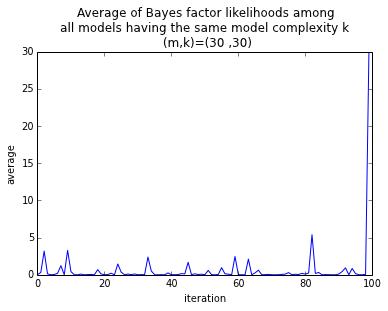

In [93]:
#print [sum(comb) for comb in random_combination(itertools.combinations([1,2,3], 1),3)]
#print calc3([1,2,3], 3,1)

# Fixed m, compute k=m/4,m/3,m/2
tau = 1.0
r = tau**2 / (1.0 + tau**2)
iters = 1e2                      # number of iterations
m = 30                        # number of channels
k = int(m)                    # model complexity
sample_size = 1               # must be smaller than the population size, i.e. C(m,k)
ii = 0 
result = []

while ii<iters:
    x = np.random.normal(0,1,m)
    temp = calc3(x,k,sample_size)      
    #print temp
    result.append(temp)
    ii = ii + 1

print result

## plot 
import pylab as pl
import scipy as sc
from scipy import misc

figure(0)
x_coor = array(xrange(len(result)))
pl.plot(x_coor, result) #print the traceplot
pl.xlabel('iteration')
pl.ylabel('average')
pl.title("Average of Bayes factor likelihoods among \nall models having the same model complexity k \n (m,k)=(" + str(int(m)) + " ,"+ str(int(k)) +")") 
pl.show

print "mean is " + str(np.mean(result)) + " and standard deviation is " + str(np.std(result)) +"; C("+ str(int(m)) + "," +str(int(k)) +")=" +str(misc.comb(int(m), int(k), exact=True)) 




In [56]:
import random
import scipy as sp
import numpy as np

import itertools
from operator import mul
from functools import reduce
from math import exp

def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(xrange(n), r))
    return tuple(pool[i] for i in indices)

def calc1(A, w):
    """ calculate ALL w consecutive products within the string A,
        If w = 1 , return [A(1)+A(2)+A(3)]/3
        If w = 2 , return [A(1)A(2)+A(1)A(3)+A(2)A(3)] /3 
        If w = 3 , return [A(1)A(2)A(3)]/1 
    """
    if w >= 1 and w <= len(A):
        l = [reduce(mul, comb) for comb in itertools.combinations(A, w)]  
    return round(sum(l)/len(l), 3)

#Fix m=30. k=7, 10, 15

tau = 1.0
r = tau**2 / (1.0 + tau**2)
iters = 50                      # number of iterations
m = 70                        # number of channels
k = int(m)                     # model complexity
sample_size = 1               # must smaller than the population size, i.e. C(m,k)
ii = 0 
result = []

m_init, m_end, elements = 10, 40, 5
m_domain = map(int, np.linspace(m_init,m_end, num_of_pts))
jj = 0 

while ii<iters:
    x = np.random.normal(0,1,m)
    B =  map(lambda x: (1.0 + tau **2)**(-0.5) + exp(x**2*r / 2.0), x )  #log-likelihood
    temp = calc1(B,k)      
    #print temp
    result.append(temp)
    ii = ii + 1

print result



#print calc2(x,3,2)
#[[i,j,k] for i in range(x+1) for j in range(y+1) for k in range(z+1) if i+j+k !=w]



[1.7895740423796385e+22, 1.4681620171598199e+19, 2.659376100530867e+20, 2.5528934679580272e+23, 5.308530820358085e+22, 3.022718327479402e+20, 3.095285073920152e+20, 6.034136963645097e+21, 2.036652281591421e+21, 1.0289522661577332e+21, 1.8555092548417023e+21, 5.057671581435513e+20, 1.959537308791989e+22, 1.874850276446567e+20, 1.4183274645074058e+22, 2.830727111721602e+21, 4.2436364725552126e+20, 1.0517356223591547e+21, 1.1356307378249353e+21, 1.7481258511684836e+21, 2.7747621829093704e+19, 8.560373698663505e+20, 3.714350184021993e+19, 4.174387333324379e+22, 3.0988498305092577e+21, 7.468440533045334e+21, 2.882778119370946e+21, 9.708415282738681e+21, 1.2329506058782646e+21, 2.868768680309682e+21, 2.6565181526893695e+21, 7.573218013673355e+20, 9.384644218210943e+19, 5.729036032541931e+21, 3.235663179134524e+20, 2.943816599845714e+21, 1.2837204401672006e+22, 2.5182833946984065e+21, 1.390763578487995e+21, 7.832935566680912e+21, 1.4864639372404075e+21, 3.8442262308021685e+20, 6.2381310349034

In [30]:
import random
import numpy as np
random.sample(xrange(100),3)
m = 30                        
k_init, k_end, k_num_pts = 1 , m , 10
k_domain = map(int, np.linspace(k_init, k_end, k_num_pts))
print k_domain

[1, 4, 7, 10, 13, 17, 20, 23, 26, 30]


In [ ]:
import pandas as pd
from pandas import *
#create dataframe: 
#column names: m (# of total covariates), k (model complexity), n (sample size) 
#row name: iterations

m = 30.0
temp = [2.085, 0.491, 0.427, 0.512, 0.827, 0.43, 0.519, 0.691, 0.606, 0.342, 0.226, 0.234, 2.877, 0.583, 0.537, 0.676, 2.988, 0.373, 0.846, 1.244, 0.843, 0.779, 0.871, 0.281, 0.662, 1.157, 0.342, 1.201, 0.577, 0.598, 1.18, 1.195, 0.659, 0.367, 1.685, 0.62, 1.665, 0.268, 0.94, 0.7, 0.495, 1.707, 0.551, 0.919, 1.753, 0.781, 1.421, 0.715, 0.546, 0.734, 0.391, 1.488, 0.808, 0.809, 1.782, 0.386, 0.706, 0.734, 0.3, 0.749, 0.542, 0.857, 0.715, 0.494, 3.586, 0.727, 0.381, 3.161, 0.938, 0.652, 0.683, 0.635, 0.576, 1.077, 1.547, 5.853, 0.72, 2.71, 0.385, 1.735, 0.505, 1.57, 0.93, 0.299, 1.858, 1.436, 0.483, 0.31, 0.531, 1.203, 0.661, 0.485, 0.288, 1.194, 0.289, 0.653, 0.435, 0.263, 0.24, 0.339, 3.858, 0.333, 0.312, 0.377, 1.648, 0.351, 0.596, 0.279, 0.65, 1.198, 1.042, 0.756, 0.438, 0.492, 1.414, 0.946, 0.716, 1.162, 0.486, 0.556, 0.778, 0.343, 0.907, 0.758, 0.465, 0.929, 0.56, 0.546, 0.636, 0.57, 0.633, 1.612, 0.357, 1.722, 0.309, 0.544, 0.833, 1.698, 0.238, 0.812, 0.374, 0.621, 0.438, 0.732, 4.168, 1.367, 0.796, 0.676, 1.016, 0.636, 0.422, 0.982, 0.538, 0.583, 0.432, 0.687, 1.519, 0.242, 2.332, 0.513, 1.419, 1.591, 1.696, 0.68, 0.782, 0.385, 0.335, 0.859, 0.886, 0.323, 0.814, 0.593, 0.208, 0.621, 1.377, 1.048, 1.037, 0.384, 0.297, 1.008, 0.505, 1.081, 0.667, 0.491, 1.045, 0.66, 1.163, 1.1, 2.321, 1.891, 0.716, 1.211, 1.4, 1.137, 1.1, 1.286, 0.499, 0.435, 1.486, 0.279, 0.757, 0.949, 0.668, 1.88, 1.518, 0.679, 0.841, 0.681, 0.634, 1.748, 0.498, 0.959, 0.58, 1.544, 0.503, 0.787, 0.648, 0.742, 0.586, 0.686, 0.582, 0.3, 2.159, 1.38, 0.343, 0.331, 0.699, 0.47, 0.488, 0.43, 1.478, 0.648, 0.707, 0.584, 0.227, 2.325, 1.361, 0.361, 0.442, 0.594, 0.776, 0.458, 0.521, 0.5, 0.612, 0.643, 4.446, 0.578, 0.461, 99.414, 0.443, 1.049, 0.741, 1.456, 0.457, 0.305, 0.589, 0.518, 0.693, 1.401, 0.437, 2.471, 0.429, 0.741, 0.491, 0.648, 0.704, 0.397, 0.343, 0.889, 1.633, 0.259, 0.443, 0.35, 0.891, 1.029, 2.265, 1.051, 0.766, 0.355, 0.428, 0.667, 0.906, 0.279, 0.364, 0.469, 0.469, 1.599, 0.461, 1.188, 0.402, 1.357, 1.117, 0.255, 0.354, 1.812, 0.577, 0.772, 1.049, 0.556, 0.537, 0.465, 1.939, 0.939, 1.735, 0.366, 0.593, 0.435, 0.428, 0.415, 4.297, 1.459, 0.474, 0.384, 2.779, 0.776, 2.156, 0.702, 0.345, 0.473, 1.373, 3.388, 0.35, 0.297, 0.886, 0.25, 0.801, 1.726, 0.98, 1.251, 0.519, 1.825, 0.977, 0.31, 0.595, 0.619, 0.834, 10.15, 0.7, 0.759, 0.384, 0.41, 0.706, 0.237, 0.218, 0.361, 0.535, 0.884, 0.984, 0.402, 6.159, 0.526, 2.294, 0.317, 0.67, 1.698, 0.878, 0.889, 1.055, 0.668, 0.265, 3.35, 0.936, 0.969, 1.093, 0.713, 0.651, 0.607, 1.365, 0.569, 0.446, 0.594, 0.464, 0.563, 1.217, 0.379, 0.442, 0.927, 0.627, 0.393, 1.583, 0.693, 0.567, 0.581, 0.739, 1.487, 1.672, 0.245, 0.333, 0.778, 0.597, 1.153, 1.135, 0.647, 0.297, 0.471, 0.567, 0.755, 1.387, 0.81, 0.458, 0.452, 0.499, 0.516, 0.589, 0.507, 2.402, 0.314, 0.913, 0.409, 0.659, 0.601, 0.319, 0.334, 0.599, 1.268, 0.374, 0.689, 0.455, 0.639, 0.386, 1.58, 0.485, 0.811, 0.625, 0.613, 0.471, 0.561, 0.273, 1.383, 1.112, 0.8, 0.77, 0.647, 0.671, 0.617, 1.138, 0.322, 0.444, 3.214, 0.677, 0.516, 0.284, 0.258, 0.363, 0.41, 0.358, 0.665, 0.417, 0.541, 0.496, 0.612, 0.689, 0.76, 0.992, 0.406, 2.149, 0.484, 0.345, 0.495, 0.952, 0.441, 0.705, 0.75, 0.736, 1.442, 0.719, 0.493, 0.573, 0.459, 1.22, 0.478, 0.918, 0.504, 0.224, 0.47, 2.489, 0.525, 0.606, 0.483, 0.422, 0.689, 0.246, 0.279, 0.8, 0.514, 0.57, 1.529, 0.291, 1.084, 0.369, 0.671, 0.473, 0.28, 0.926, 0.355, 0.408, 1.382, 0.256, 0.375, 0.97, 0.307, 0.779, 0.308, 0.323, 0.548, 0.632, 4.5, 1.22, 0.369, 3.101, 1.813, 0.776, 0.732, 0.671, 0.881, 0.49, 0.325, 1.653, 0.355, 0.478, 1.926, 0.235, 0.686, 2.158, 0.328, 0.363, 1.892, 0.511, 0.359, 1.076, 0.664, 1.649, 0.521, 2.061, 1.093, 0.914, 2.264, 0.321, 0.289, 0.523, 0.607, 0.682, 1.016, 0.735, 1.022, 0.497, 0.476, 0.905, 0.779, 1.36, 0.547, 1.545, 0.262, 0.844, 0.571, 0.531, 0.668, 0.514, 0.223, 0.271, 2.518, 0.363, 1.012, 0.835, 0.216, 0.697, 4.227, 0.23, 0.332, 0.328, 1.671, 0.462, 0.465, 0.391, 0.97, 1.191, 0.296, 0.552, 0.514, 0.626, 0.422, 0.436, 0.577, 0.761, 0.4, 2.234, 0.888, 0.93, 1.018, 0.579, 1.317, 0.788, 0.533, 0.377, 0.524, 0.565, 1.159, 1.177, 0.38, 0.976, 1.126, 1.061, 1.098, 0.33, 0.391, 0.535, 2.103, 1.574, 0.733, 0.643, 0.56, 0.406, 0.399, 0.7, 0.694, 0.441, 0.955, 0.618, 0.443, 2.283, 0.303, 0.597, 0.501, 0.601, 1.185, 0.57, 0.744, 0.702, 1.31, 0.992, 0.632, 0.934, 0.685, 1.284, 1.594, 0.604, 0.312, 3.273, 1.497, 1.459, 0.782, 0.943, 0.685, 0.509, 0.348, 0.815, 0.426, 4.35, 0.507, 0.652, 0.325, 0.643, 0.322, 0.334, 0.648, 1.106, 0.628, 0.736, 0.818, 0.257, 0.549, 0.678, 0.297, 0.839, 1.369, 0.377, 0.655, 0.521, 0.355, 0.353, 0.47, 0.378, 0.864, 0.533, 1.313, 1.821, 0.594, 0.323, 0.242, 1.635, 0.584, 0.908, 0.924, 0.522, 1.73, 2.417, 4.761, 0.321, 0.481, 0.733, 0.805, 0.336, 1.041, 0.439, 0.417, 0.824, 1.186, 0.653, 0.253, 1.199, 1.465, 2.293, 0.369, 0.455, 2.325, 0.82, 8.525, 0.994, 1.059, 0.265, 1.393, 0.788, 0.744, 0.679, 0.992, 0.629, 0.376, 0.326, 0.78, 1.156, 0.842, 0.294, 0.4, 0.445, 1.741, 2.179, 0.682, 0.842, 0.509, 0.389, 0.908, 1.846, 0.813, 0.981, 0.354, 0.341, 0.365, 0.539, 1.04, 0.456, 1.28, 0.429, 0.346, 1.122, 1.386, 0.435, 0.215, 0.653, 0.378, 1.236, 0.582, 0.928, 0.248, 0.216, 0.356, 6.598, 1.097, 0.382, 0.458, 0.52, 0.952, 2.399, 0.804, 2.116, 1.397, 0.647, 0.738, 1.155, 2.589, 0.528, 0.744, 0.34, 0.243, 0.714, 0.526, 0.309, 0.669, 0.277, 0.337, 0.475, 1.126, 0.386, 0.87, 0.286, 0.478, 0.731, 0.33, 0.431, 0.478, 0.71, 0.904, 0.632, 1.508, 5.217, 3.01, 0.301, 0.499, 0.809, 0.331, 0.546, 2.15, 1.582, 0.775, 0.462, 0.618, 1.431, 1.775, 0.399, 0.296, 0.418, 0.554, 0.764, 1.144, 0.47, 0.362, 1.001, 0.834, 1.423, 0.523, 2.754, 0.318, 0.518, 0.334, 0.591, 1.716, 2.454, 1.864, 0.588, 0.621, 0.399, 0.998, 0.376, 1.405, 0.515, 0.519, 0.813, 1.017, 0.611, 0.476, 0.933, 0.476, 3.402, 0.382, 0.718, 0.445, 1.409, 0.388, 1.377, 0.457, 0.926, 0.598, 0.355, 2.03, 3.151, 0.838, 1.717, 0.553, 0.367, 0.479, 0.504, 4.018, 0.327, 2.626, 0.598, 1.569, 0.621, 0.432, 1.508, 1.099, 1.609, 1.378, 0.84, 0.541, 0.606, 0.916, 0.857, 0.492, 0.743, 0.554, 0.606, 1.314, 1.27, 0.309, 4.383, 1.26, 0.563, 1.228, 1.782, 0.761, 0.782, 0.777, 0.372, 0.428, 14.286, 0.218, 0.608, 0.392, 0.813, 0.538, 0.572, 0.806, 0.644, 2.195, 0.553, 1.23, 0.935, 0.592, 1.351, 0.257, 0.543, 0.908, 0.418, 0.46, 1.039, 0.273, 0.279, 0.31, 4.742, 2.978, 1.457, 0.984, 1.446, 0.593, 0.662, 1.195, 0.332, 0.741, 10.315, 1.134, 0.644, 0.667, 0.207, 0.453, 0.291, 1.67, 0.445, 1.863, 3.747, 1.202, 0.533, 0.766, 0.793, 0.869, 0.303, 1.569, 0.355, 0.481, 1.208, 0.425, 0.773, 0.901, 0.292, 0.324, 0.414, 0.449, 0.552, 1.652, 0.96, 0.427, 0.811, 0.916, 0.942, 3.753, 1.03, 1.431, 0.303, 0.589, 0.7, 0.7, 0.573, 0.596, 0.724, 0.408, 0.311, 0.675, 0.945, 1.415, 0.468, 0.639, 0.381, 0.544, 0.931, 0.351, 1.959, 0.426, 0.578, 1.827, 0.548, 0.58, 0.686, 0.692, 0.802, 0.707, 0.441, 0.718, 35.465, 0.516, 0.984, 0.39]



In [ ]:

def boxplot(temp_input, temp_k, log_or_not):
    if log_or_not == True :
        plt.boxplot(log_elementwise(temp_input))
        plt.title("Logarithm Average of Bayes factor likelihoods among \nall models having the same model complexity k =" + str(temp_k)) #temp_k is in the title
        plt.ylabel('log-average Bayes factors')
    else:
        plt.boxplot(temp_input)
        plt.title("Average of Bayes factor likelihoods among \nall models having the same model complexity k =" + str(temp_k)) #temp_k is in the title
        plt.ylabel('average Bayes factors')
    plt.xlabel('m')
    pylab.xticks(range(1,len(m_domain)+1), m_domain)
    
def calc1_rnd(dat, w, r):
    A =  map(lambda x: (1.0 + tau **2)**(-0.5) * exp(r / 2.0 * x**2), dat)
    if w >= 1 and w <= len(A):
        all_comb = itertools.combinations(A, w)   
        l = [reduce(mul, comb) for comb in random_combination(all_comb, r)] 
    print "len l is " + str(len(l))+ "; r is " + str(r)
    return round(sum(l)/len(l),7)


def calc2(dat, w, r):
    """ input: A: array of likelihoods, k: model complexity, r:# of random samples from C(m,k) models with the same k
        output: average of likelihoods among these r samples.
        randomly select r samples out of C(len(A),k pool. 
        The pool consists of all distinct summation within the string A (= log likelihood)
        If (n,w,r)=(3,2,1): randomly draw 1 sample from A(1)+A(2) , A(1)+A(3) , A(2)+A(3)"""
    A =  map(lambda x: (1.0 + tau **2)**(-0.5) * exp(x**2*r / 2.0), dat)
    if w >= 1 and w <= len(A):
        all_comb = itertools.combinations(A, w)
       # l = [reduce(mul, comb) for comb in random_combination(all_comb, r)] 
        random_combination(all_comb, r)
    return round(sum(l)/len(l),7)



def calc4(dat, w, r, m, a, b):
    """ same as calc3, with p~Beta(a,b)"""
    A =  map(lambda x: -0.5 * log(1.0 + tau **2) + x**2*r / 2.0 , dat)  #log-likelihood
    m = len(dat)
    if w >= 1 and w <= len(A):
        all_comb = itertools.combinations(A, w)
        l = [sum(comb) for comb in random_combination(all_comb, r)]  
    B =  map(exp, l)
    return round(sum(B)/len(B)*gamma(a+b)/gamma(a)/gamma(b)*gamma(m-w+a)*gamma(b+w)/gamma(m+a+b) , 7)


In [ ]:
import itertools
sample = itertools.combinations([1,2,3], 2)
for comb1 in sample:
    print comb1

print "split"

for comb2 in sample:
    print comb2

    
all_comb = itertools.combinations(A, w)   
l = [reduce(mul, comb) for comb in random_combination(itertools.combinations(A,w), r)] 
print l
